# Energy Usage in European Union
This notebook contains the code for the lecture DOPP WS23 on the topic of energy usage and development in European Union.
In each section heading it is clarified who worked on this part of the code.

# Team 
- Anna Sophia Stonek (11809899)
- Stefan Helm (11938265)
- Thomas Laner (11807845)
- Marko Gugleta (12016483)

## Story
"Through this analysis of European Union's energy data we want to show how close is this region to successfully transitioning away from fossil fuels, and what might be still key obstacles need to be addressed."

## Specific Questions
The purpose of this project is to answer the following questions:
1. How has European Union’s dependence on different types of fossil fuels, particularly Oil, Natural gas and Solid fossil fuels changed since 2010?
2. What are the primary industrial and domestic uses of fossil and renewable fuels in European Union, and how have these usages
changed since 2010?
3. How do fluctuations in electricity, natural gas, oil end-user prices, affect the consumption of these goods
(correlation, other influences)? How do they affect the share of renewable energy in gross final energy
consumption?
4. Identify the main external and internal sources of fossil fuels for European Union. How has the reliance on these
sources shifted over time?


## Setup
This section contains all the nessesary setup for the code. Imports and helper functions. 

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from IPython.display import display

### Helper Functions (Thomas Laner / Marko Gugleta)

In [2]:
def import_estat_dataset(file_path, split_col_names):
    '''
    Imports the dataset from the given file path, splits the first column into multiple columns,
    and concatenates these columns with the rest of the dataset.
    
    Args:
        file_path (str): Path to the dataset file.
        split_col_names (list of str): Names for the columns obtained by splitting the first column.

    Returns:
        data (pandas.DataFrame): The processed dataset.
    '''

    # Read the dataset
    data = pd.read_csv(file_path, sep='\t')

    # Splitting the combined column
    split_columns = data.iloc[:, 0].str.split(',', expand=True)
    split_columns.columns = split_col_names

    # Concatenate the split columns with the original data (excluding the first combined column)
    data = pd.concat([split_columns, data.iloc[:, 1:]], axis=1)

    return data

def print_unique_values(data, column_list):
    """
    Prints the number of unique values for each column in a given list.

    Args:
        data (pandas.DataFrame): The DataFrame containing the data.
        column_list (list of str): The list of column names.

    """
    for column in column_list:
        unique_values = data[column].nunique()
        print(f"The column '{column}' has {unique_values} unique value(s).")

def replace_colon_with_none(df):
    """
    Replaces all cells containing ':' with None in a pandas DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame to modify.

    Returns:
        modified_df (pandas.DataFrame): The modified DataFrame.
    """
    modified_df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    modified_df = modified_df.applymap(lambda x: None if isinstance(x, str) and ':' in x else x)
    return modified_df



def melt_data(df, id_vars, value_vars, var_name, value_name):
    """
    Melts the DataFrame and converts 'year' to a numeric type.

    Args:
        df (pandas.DataFrame): The DataFrame to melt.
        id_vars (list of str): The columns to keep as is.
        value_vars (list of str): The columns to melt.
        var_name (str): The name of the variable column.
        value_name (str): The name of the value column.
    
    Returns:
        melted_df (pandas.DataFrame): The melted DataFrame.
    """
    melted_df = df.melt(id_vars=id_vars, value_vars=value_vars, var_name=var_name, value_name=value_name)
    melted_df[var_name] = pd.to_numeric(melted_df[var_name].str.strip())
    return melted_df

def plot_dual_axis(data, x, y1, y2, title, y1_label, y2_label, xlabel='Year'):
    """
    Plots two different metrics on the same graph with dual y-axes.

    Args:
        data (pandas.DataFrame): The DataFrame containing the data to plot.
        x (str): The name of the column containing the x-axis values.
        y1 (str): The name of the column containing the first y-axis values.
        y2 (str): The name of the column containing the second y-axis values.
        title (str): The title of the plot.
        y1_label (str): The label for the first y-axis.
        y2_label (str): The label for the second y-axis.
        xlabel (str): The label for the x-axis.
    """
    fig, ax1 = plt.subplots(figsize=(12, 7))
    plt.grid(True)

    # Plot the first metric
    color = 'tab:blue'
    sns.lineplot(x=data[x], y=data[y1], color=color, ax=ax1)
    ax1.set_xlabel(xlabel, fontsize=12)
    ax1.set_ylabel(y1_label, fontsize=12, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second axis for the second metric
    ax2 = ax1.twinx()
    color = 'tab:red'
    sns.lineplot(x=data[x], y=data[y2], color=color, ax=ax2)
    ax2.set_ylabel(y2_label, fontsize=12, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Set x-ticks to unique years and rotate for readability
    ax1.set_xticks(data[x].unique())
    ax1.set_xticklabels(data[x].unique(), rotation=45)
    plt.xlim(min(data[x]), max(data[x]))  # Set x-axis limit to data range

    # Set the title and layout
    plt.title(title, fontsize=14)
    fig.tight_layout()

    # Add a legend manually
    ax1.legend([ax1.lines[0], ax2.lines[0]], [y1_label, y2_label], bbox_to_anchor=(0.5, 1), loc='upper left')

    plt.show()

def plot_multi_category(data, x, y, hue, style, title, ylabel, xlabel='Year'):
    """
    Plots lines for different categories of the same metric on the same y-axis, with the hue
    defining the color and the style defining the line style. Allows for custom x and y labels.

    Args:
        data (pandas.DataFrame): The DataFrame containing the data to plot.
        x (str): The name of the column containing the x-axis values.
        y (str): The name of the column containing the y-axis values.
        hue (str): The name of the column containing the categories.
        style (str): The name of the column containing the line styles.
        title (str): The title of the plot.
        ylabel (str): The label for the y-axis.
        xlabel (str): The label for the x-axis.
    """
    plt.figure(figsize=(12, 7))
    sns.lineplot(data=data, x=x, y=y, hue=hue, style=style)
    plt.title(title, fontsize=14)
    plt.ylabel(ylabel, fontsize=12)
    plt.xlabel(xlabel, fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title=hue, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(data[x].unique())
    plt.show()

def plot_imports_all(dataset, country):
    test_data = dataset[dataset['geo'] == country]

    fig, ax = plt.subplots(3, 2, figsize=(12, 16))
    fig.tight_layout(pad=10.0)
    fig.suptitle('Oil imports for ' + country + ' from 2015 to 2020')
    c = 0
    r = 0
    for year in list(range(2015, 2021)):
        for p in dataset['partner'].unique():
            ax[c, r].bar(p, test_data[test_data['partner'] == p][year], label=p)
        ax[c, r].set_title('Oil imports in ' + str(year) + ' for ' + country)
        ax[c, r].set_xlabel('Partner')
        ax[c, r].set_ylabel('%')
        ax[c, r].set_xticklabels(dataset['partner'].unique())
        ax[c, r].tick_params(axis='x', rotation=45)
        if r == 1:
            r = 0
            c += 1
        else:
            r += 1
    plt.plot()
    plt.show()

def plot_changes(dataset, country):
    test_data = dataset[dataset['geo'] == country]

    for p in dataset['partner'].unique():
        plt.plot(list(range(2015, 2021)), (test_data[test_data['partner'] == p][list(list(range(2015, 2021)))].astype(float)).values[0], label=p)
    plt.title('Oil imports for ' + country + ' from 2015 to 2020')
    plt.legend(loc="best", fontsize="6")
    plt.xlabel('Year')
    plt.ylabel('%')
    plt.xticks(rotation=45)
    plt.show()


def plot_overall(dataset, country):
    test_data = dataset[dataset['geo'] == country]

    for p in list(range(2015, 2021)):
        plt.bar(p, sum((test_data[p])), label=p)

    plt.title('Oil imports for ' + country + ' from 2015 to 2020 overall')
    plt.xlabel('Year')
    plt.ylabel('%')
    plt.xticks(rotation=45)
    plt.show()

def plot_overall_all(dataset):
    test_data = dataset

    for p in list(range(2015, 2021)):
        l = []
        for c in dataset['geo'].unique():
            l.append(sum((test_data[test_data['geo'] == c][p])))            
        plt.bar(p, np.array(l).mean(), label=p)

    plt.title('Oil imports for the whole Europe from 2015 to 2020 overall')
    plt.xlabel('Year')
    plt.ylabel('%')
    plt.xticks(rotation=45)
    plt.show()

def plot_overall_partner(dataset):
    for p in dataset['partner'].unique():
        plt.bar(p, (dataset[dataset['partner'] == p][list(list(range(2015, 2021)))].astype(float)).mean(axis=1).sum(), label=p)
    plt.title('Oil imports from 2015 to 2020 overall')
    plt.xlabel('Country')
    plt.ylabel('%')
    plt.xticks(rotation=45)
    plt.show()

def plot_yearly_partner(dataset):

    fig, ax = plt.subplots(3, 2, figsize=(12, 16))
    fig.tight_layout(pad=10.0)
    fig.suptitle('Oil imports from 2015 to 2020')
    c = 0
    r = 0
    for year in list(range(2015, 2021)):
        for p in dataset['partner'].unique():
            ax[c, r].bar(p, (dataset[dataset['partner'] == p][[year]].astype(float)).mean(axis=1).sum(), label=p)
        ax[c, r].set_title('Oil imports in ' + str(year))
        ax[c, r].set_xlabel('Partner')
        ax[c, r].set_ylabel('%')
        ax[c, r].set_xticklabels(dataset['partner'].unique())
        ax[c, r].tick_params(axis='x', rotation=45)
        if r == 1:
            r = 0
            c += 1
        else:
            r += 1
    plt.plot()
    plt.show()


## Data Understanding and Preperation

In this section we will load our datasets and check what columns are in there and what meaning they have. Furthermore we will chcke if any preprocessing is needed and try to merge the dataset as good as possible to one big dataset together.

### Simplified Energy Balance (Europe) (Anna Sophia Stonek / Stefan Helm)

**Source:** [estat_nrg_bal_s.tsv](https://ec.europa.eu/eurostat/databrowser/bulk?lang=en&searchFilter=nrg_bal_s)

The energy balance contains infromation of energy products (fuels) and energy flows (production – transformation – consumption sectors) for Europe.

We will use this dataset to extract infromation for the industry and where the energy is used.

In [3]:
columns_energy_balance = ['freq', 'nrg_bal', 'siec', 'unit', 'geo']
energy_balance = import_estat_dataset('data/estat_nrg_bal_s.tsv', columns_energy_balance)
energy_balance.head(3)

freq nrg_bal             siec unit geo       1990        1991        1992    
0    A     AFC  C0000X0350-0370  GWH  AL   6644.088    3816.945    1067.475   \
1    A     AFC  C0000X0350-0370  GWH  AT  12661.389   13590.083   11523.667    
2    A     AFC  C0000X0350-0370  GWH  BA          :           :           :    

        1993       1994   ...      2013       2014       2015       2016    
0    525.540    459.514   ...   779.266   1005.406   1094.259    580.819   \
1  10434.278   9353.833   ...  4443.802   4384.997   4341.902   4376.606    
2          :          :   ...         :   3142.427   3271.128   3209.039    

       2017       2018       2019       2020       2021       2022   
0  1432.220   2780.662   1436.330   1752.246   2640.835          :   
1  4261.576   3897.165   3900.608   4261.574   4143.360   3480.413   
2  3080.546   3243.089   2383.784   2716.557   3328.823          :   

[3 rows x 38 columns]

In [4]:
energy_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134634 entries, 0 to 134633
Data columns (total 38 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   freq     134634 non-null  object
 1   nrg_bal  134634 non-null  object
 2   siec     134634 non-null  object
 3   unit     134634 non-null  object
 4   geo      134634 non-null  object
 5   1990     134634 non-null  object
 6   1991     134634 non-null  object
 7   1992     134634 non-null  object
 8   1993     134634 non-null  object
 9   1994     134634 non-null  object
 10  1995     134634 non-null  object
 11  1996     134634 non-null  object
 12  1997     134634 non-null  object
 13  1998     134634 non-null  object
 14  1999     134634 non-null  object
 15  2000     134634 non-null  object
 16  2001     134634 non-null  object
 17  2002     134634 non-null  object
 18  2003     134634 non-null  object
 19  2004     134634 non-null  object
 20  2005     134634 non-null  object
 21  2006     1

We can see that we have 38 columns with 134634 rows. The first 5 columns contains information about the fuel (siec), the unit (unit), the country (geo), freqence (freq) and flow of the fuel (nrg_bal). The remaining columns are the values of each year starting at 1990 till 2022.

In [5]:
print_unique_values(energy_balance, columns_energy_balance)

The column 'freq' has 1 unique value(s).
The column 'nrg_bal' has 92 unique value(s).
The column 'siec' has 12 unique value(s).
The column 'unit' has 3 unique value(s).
The column 'geo' has 41 unique value(s).


Here we can see that we have that the freq has just one value, which is anual. So we drop this column. We have 92 different flows, 12 different fuel types to map. Three units to standardize and 41 different countries. 

In [6]:
energy_balance[energy_balance['geo'] == 'AT']

freq nrg_bal             siec  unit geo        1990         1991    
1         A     AFC  C0000X0350-0370   GWH  AT   12661.389    13590.083   \
42        A     AFC  C0000X0350-0370  KTOE  AT    1088.683     1168.537    
83        A     AFC  C0000X0350-0370    TJ  AT   45581.000    48924.300    
124       A     AFC       C0350-0370   GWH  AT    2342.444     2302.944    
165       A     AFC       C0350-0370  KTOE  AT     201.414      198.018    
...     ...     ...              ...   ...  ..          ...          ...   
134433    A  TO_RPI            TOTAL  KTOE  AT    9095.391     9557.565    
134474    A  TO_RPI            TOTAL    TJ  AT  380805.850   400156.138    
134515    A  TO_RPI       W6100_6220   GWH  AT          : z          : z   
134555    A  TO_RPI       W6100_6220  KTOE  AT          : z          : z   
134595    A  TO_RPI       W6100_6220    TJ  AT          : z          : z   

              1992         1993         1994   ...        2013         2014    
1        11523.667    10434.278     9353.833   ...    4443.802     4384.997   \
42         990.857      897.186      804.285   ...     382.098      377.042    
83       41485.200    37563.400    33673.800   ...   15997.688    15785.988    
124       1821.917     1347.611     1338.833   ...    1110.101      962.695    
165        156.657      115.874      115.119   ...      95.451       82.777    
...             ...          ...          ...  ...          ...          ...   
134433    9760.525     9811.892     9998.343   ...    9319.893     9249.687    
134474  408653.640   410804.277   418610.638   ...  390205.284   387265.894    
134515          : z          : z          : z  ...          : z          : z   
134555          : z          : z          : z  ...          : z          : z   
134595          : z          : z          : z  ...          : z          : z   

              2015         2016         2017         2018         2019    
1         4341.902     4376.606     4261.576     3897.165     3900.608   \
42         373.336      376.320      366.430      335.096      335.392    
83       15630.847    15755.782    15341.673    14029.793    14042.190    
124        936.920     1162.469     1218.890     1024.911     1114.965    
165         80.561       99.954      104.806       88.126       95.870    
...             ...          ...          ...          ...          ...   
134433    9643.935     8789.977     8880.785     9505.645     9792.657    
134474  403772.262   368018.748   371820.712   397982.346   409998.956    
134515          : z          : z          : z          : z          : z   
134555          : z          : z          : z          : z          : z   
134595          : z          : z          : z          : z          : z   

              2020         2021         2022   
1         4261.574     4143.360     3480.413   
42         366.429      356.265      299.262   
83       15341.667    14916.095    12529.486   
124        945.660     1301.362     1150.732   
165         81.312      111.897       98.945   
...             ...          ...          ...  
134433    8816.216     8578.211     6441.596   
134474  369117.345   359152.518   269696.750   
134515          : z          : z          : z  
134555          : z          : z          : z  
134595          : z          : z          : z  

[3312 rows x 38 columns]

Here we can also see that for one siec code (fuel_type) multiple rows with different units exist. We will only keep those rows with GWH as unit. And we check if there is any combination of nrg_bal,siec,geo where GWH is not a possible unit, because then we would need to do some convertion.

In [7]:
result = energy_balance.groupby(['nrg_bal', 'geo', 'siec'])['unit'].apply(lambda x: 'GWH' in x.values).reset_index(name='GWH_available')
result[result['GWH_available'] == False]

Empty DataFrame
Columns: [nrg_bal, geo, siec, GWH_available]
Index: []

In [8]:
energy_balance = energy_balance[energy_balance['unit'] == 'GWH']

Regarding the flows we will filter the dataset on the follwowing flows:
- IMP: Imports
- EXP: Exports
- FC_IND_E: Final consumption - industry sector - energy use
- FC_IND_IS_E: Final consumption - industry sector - iron and steel - energy use
- FC_IND_CPC_E: Final consumption - industry sector - chemical and petrochemical - energy use
- FC_IND_NFM_E: Final consumption - industry sector - non-ferrous metals - energy use
- FC_IND_NMM_E: Final consumption - industry sector - non-metallic minerals - energy use
- FC_IND_TE_E: Final consumption - industry sector - transport equipment - energy use
- FC_IND_MAC_E: Final consumption - industry sector - machinery - energy use
- FC_IND_MQ_E: Final consumption - industry sector - mining and quarrying - energy use
- FC_IND_FBT_E: Final consumption - industry sector - food, beverages and tobacco - energy use
- FC_IND_PPP_E: Final consumption - industry sector - paper, pulp and printing - energy use
- FC_IND_WP_E: Final consumption - industry sector - wood and wood products - energy use
- FC_IND_CON_E: Final consumption - industry sector - construction - energy use
- FC_IND_TL_E: Final consumption - industry sector - textile and leather - energy use
- FC_IND_NSP_E: Final consumption - industry sector - not elsewhere specified - energy use

The mapping information can be found in the document provided in the documentation folder in the file nrg_bal_s.pdf on page 11.

For the fuel mapping we can import the dataset [siec.csv](https://dd.eionet.europa.eu/vocabulary/eurostat/siec/view) to map our siec codes to fuel names.

In [9]:
siec_code = pd.read_csv('data/siec.csv', sep=',')
siec_code.head(3)

URI   
0  http://dd.eionet.europa.eu/vocabulary/eurostat...  \
1  http://dd.eionet.europa.eu/vocabulary/eurostat...   
2  http://dd.eionet.europa.eu/vocabulary/eurostat...   

                           Label  Definition Notation Status AcceptedDate  
0                          Total         NaN    TOTAL  valid   2018-12-07  
1              Combustible fuels         NaN       CF  valid   2018-12-07  
2  Combustible fuels - renewable         NaN     CF_R  valid   2018-12-07

In [10]:
siec_code.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   URI           285 non-null    object 
 1   Label         285 non-null    object 
 2   Definition    0 non-null      float64
 3   Notation      285 non-null    object 
 4   Status        285 non-null    object 
 5   AcceptedDate  285 non-null    object 
dtypes: float64(1), object(5)
memory usage: 13.5+ KB


In [11]:
siec_code = siec_code[['Label', 'Notation']]

We see that under siec codes that we have 285 codes (notation) avaiable, which we will use for our mapping.

In [12]:
#drop freq column
energy_balance.drop('freq', axis=1, inplace=True)

energy_balance = energy_balance.merge(siec_code, left_on='siec', right_on='Notation', how='left')
energy_balance.drop(['Notation'], axis=1, inplace=True)

#relevant flows
relevant_flows = [
    "IMP", 
    "EXP", 
    "FC_IND_E",
    "FC_IND_IS_E",
    "FC_IND_CPC_E",
    "FC_IND_NFM_E",
    "FC_IND_NMM_E",
    "FC_IND_TE_E",
    "FC_IND_MAC_E",
    "FC_IND_MQ_E",
    "FC_IND_FBT_E",
    "FC_IND_PPP_E",
    "FC_IND_WP_E",
    "FC_IND_CON_E",
    "FC_IND_TL_E",
    "FC_IND_NSP_E"
]
flows_mapping = {
    "IMP": "Imports",
    "EXP": "Exports",
    "FC_IND_E": "Industry - All",
    "FC_IND_IS_E": "Industry - Iron and steel",
    "FC_IND_CPC_E": "Industry - Chemicals and petrochemicals",
    "FC_IND_NFM_E": "Industry - Non-ferrous metals",
    "FC_IND_NMM_E": "Industry - Non-metallic minerals",
    "FC_IND_TE_E": "Industry - Transport equipment",
    "FC_IND_MAC_E": "Industry - Machinery",
    "FC_IND_MQ_E": "Industry - Mining and quarrying",
    "FC_IND_FBT_E": "Industry - Food, beverages and tobacco",
    "FC_IND_PPP_E": "Industry - Pulp, paper and printing",
    "FC_IND_WP_E": "Industry - Wood and wood products",
    "FC_IND_CON_E": "Industry - Construction",
    "FC_IND_TL_E": "Industry - Textiles and leather",
    "FC_IND_NSP_E": "Industry - Non-specified"
}
energy_balance = energy_balance[energy_balance['nrg_bal'].isin(relevant_flows)]
energy_balance['nrg_bal'] = energy_balance['nrg_bal'].replace(flows_mapping)


In [13]:
energy_balance.head(3)

nrg_bal             siec unit geo     1990      1991      1992     1993    
983  Exports  C0000X0350-0370  GWH  AL  623.390   273.417   273.417   21.873   \
984  Exports  C0000X0350-0370  GWH  AT   27.259    55.694   176.990   54.324    
985  Exports  C0000X0350-0370  GWH  BA        :         :         :        :    

      1994     1995   ...      2014       2015       2016       2017    
983  0.000    0.000   ...     0.000      0.000      0.000      0.000   \
984  0.000   21.056   ...    18.575    573.584    405.039    422.345    
985      :        :   ...  4158.681   3640.547   3762.987   3138.718    

         2018       2019       2020       2021      2022                Label  
983     0.000      0.000      0.000      0.000         :   Solid fossil fuels  
984   444.978    387.222    304.602    452.424   414.724   Solid fossil fuels  
985  5058.286   4087.264   3357.003   3770.356         :   Solid fossil fuels  

[3 rows x 38 columns]

Furthermore our time window we are interested starts at 2010 so we will drop the years before.

In [14]:
energy_balance.drop(energy_balance.columns[4:24], axis=1, inplace=True)

We also see that for some years we don't have any data which is indecaded with ':' we will null those values.


In [15]:
energy_balance = replace_colon_with_none(energy_balance)
energy_balance.head(3)

nrg_bal             siec unit geo   2010    2011    2012    2013    
983  Exports  C0000X0350-0370  GWH  AL   0.000   0.000   0.000   0.000  \
984  Exports  C0000X0350-0370  GWH  AT  54.812  28.210  20.397  14.441   
985  Exports  C0000X0350-0370  GWH  BA    None    None    None    None   

        2014      2015      2016      2017      2018      2019      2020    
983     0.000     0.000     0.000     0.000     0.000     0.000     0.000  \
984    18.575   573.584   405.039   422.345   444.978   387.222   304.602   
985  4158.681  3640.547  3762.987  3138.718  5058.286  4087.264  3357.003   

        2021     2022                Label  
983     0.000     None  Solid fossil fuels  
984   452.424  414.724  Solid fossil fuels  
985  3770.356     None  Solid fossil fuels

Now we will pivot the data to make it easier to merge later on.

In [16]:
energy_balance = melt_data(energy_balance, ['nrg_bal', 'siec', 'unit', 'geo', 'Label'], energy_balance.columns[4:], 'year', 'gwh')
energy_balance.drop('unit', axis=1, inplace=True)
#rename siec to fuel_type
energy_balance.rename(columns={'Label': 'fuel', 'nrg_bal': 'usage', 'geo': 'country_code'}, inplace=True)
#convert gwh to float
energy_balance['gwh'] = energy_balance['gwh'].astype(float)
energy_balance.head(3)

usage             siec country_code                fuel  year     gwh
0  Exports  C0000X0350-0370           AL  Solid fossil fuels  2010   0.000
1  Exports  C0000X0350-0370           AT  Solid fossil fuels  2010  54.812
2  Exports  C0000X0350-0370           BA  Solid fossil fuels  2010     NaN

In [17]:
#group by usage, fuel_type, country_code, year to get total gwh
energy_balance = energy_balance.groupby(['usage', 'siec', 'fuel', 'country_code', 'year']).sum().reset_index()

In [18]:
energy_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102128 entries, 0 to 102127
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   usage         102128 non-null  object 
 1   siec          102128 non-null  object 
 2   fuel          102128 non-null  object 
 3   country_code  102128 non-null  object 
 4   year          102128 non-null  int64  
 5   gwh           102128 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 4.7+ MB


In [19]:
energy_balance['country_code'].unique()

array(['AL', 'AT', 'BA', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL',
       'ES', 'EU27_2020', 'FI', 'FR', 'GE', 'HR', 'HU', 'IE', 'IS', 'IT',
       'LT', 'LU', 'LV', 'MD', 'ME', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT',
       'RO', 'RS', 'SE', 'SI', 'SK', 'TR', 'UA', 'UK', 'XK'], dtype=object)

In [20]:
master_df = energy_balance.copy()

Now we finally finished cleaning up our first dataset which will be used as the main dataset to add information to it. 

### EuroStat Usage Data for Households (Stefan Helm)

**Source:** 
- [estat_nrg_d_hhq.tsv](https://data.europa.eu/data/datasets/uvygjkxev6pywqwbgmgwyg?locale=en)

This data set contains the disaggregated final energy consumption for households, so we get a more detailed view later where the energy with which fuel is used.

In [21]:
columns_energy_use_households = ['freq', 'nrg_bal', 'siec', 'unit', 'geo']
energy_use_households = import_estat_dataset('data/estat_nrg_d_hhq.tsv', columns_energy_use_households)
energy_use_households.head(3)

freq      nrg_bal   siec unit geo       2010        2011        2012    
0    A  FC_OTH_HH_E  E7000  GWH  AL   2997.450    2936.634    3065.799   \
1    A  FC_OTH_HH_E  E7000  GWH  AT  17657.493   17273.639   17541.316    
2    A  FC_OTH_HH_E  E7000  GWH  BA          :           :           :    

        2013        2014        2015        2016        2017        2018    
0   4066.970    3500.001    3240.375    2990.930    2934.535    3146.976   \
1  17649.164   16815.552   17215.299   17838.838   17998.218   17942.604    
2          :    4604.000    4725.000    4734.000    4755.000    4685.000    

        2019        2020        2021   
0   3120.242    3469.079    3504.652   
1  18336.543   18006.175   20283.197   
2   4725.999    4795.000    4912.000

In [22]:
energy_use_households.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3552 entries, 0 to 3551
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   freq     3552 non-null   object
 1   nrg_bal  3552 non-null   object
 2   siec     3552 non-null   object
 3   unit     3552 non-null   object
 4   geo      3552 non-null   object
 5   2010     3552 non-null   object
 6   2011     3552 non-null   object
 7   2012     3552 non-null   object
 8   2013     3552 non-null   object
 9   2014     3552 non-null   object
 10  2015     3552 non-null   object
 11  2016     3552 non-null   object
 12  2017     3552 non-null   object
 13  2018     3552 non-null   object
 14  2019     3552 non-null   object
 15  2020     3552 non-null   object
 16  2021     3552 non-null   object
dtypes: object(17)
memory usage: 471.9+ KB


In [23]:
#strip column names of whitespace
energy_use_households.columns = energy_use_households.columns.str.strip()

In [24]:
print_unique_values(energy_use_households, columns_energy_use_households)

The column 'freq' has 1 unique value(s).
The column 'nrg_bal' has 7 unique value(s).
The column 'siec' has 15 unique value(s).
The column 'unit' has 4 unique value(s).
The column 'geo' has 39 unique value(s).


We see that we have 7 different usages in households (nrg_bal) for engery which are using 15 differenct fuel_types (siec) in 4 differenct units in 39 different locations.

In [25]:
print(energy_use_households['unit'].unique())
print(energy_use_households['nrg_bal'].unique())
print(energy_use_households['siec'].unique())

['GWH' 'TJ' 'TJ_GCV' 'THS_T']
['FC_OTH_HH_E' 'FC_OTH_HH_E_CK' 'FC_OTH_HH_E_LE' 'FC_OTH_HH_E_OE'
 'FC_OTH_HH_E_SC' 'FC_OTH_HH_E_SH' 'FC_OTH_HH_E_WH']
['E7000' 'G3000' 'G3200' 'H8000' 'O4000' 'O4669' 'O4671'
 'R5110-5150_W6000RI' 'R5300' 'RA000' 'RA410' 'RA600' 'SFF_P1000_S2000'
 'TOTAL' 'O4630']


First we will drop the freq beacuse it is anual again and add the siec label to our data.

In [26]:
#drop freq column
energy_use_households.drop('freq', axis=1, inplace=True)

energy_use_households = energy_use_households.merge(siec_code, left_on='siec', right_on='Notation', how='left')
energy_use_households.drop(['Notation'], axis=1, inplace=True)

Now we can map the useage by searching the codes on this webpage [here](https://dd.eionet.europa.eu/vocabulary/eurostat/nrg_bal/view) and create a mapping.

In [27]:
households_usage = {
    'FC_OTH_HH_E' : 'Households - All',
    'FC_OTH_HH_E_CK': 'Households - Cooking',
    'FC_OTH_HH_E_LE': 'Households - Lighting',
    'FC_OTH_HH_E_OE': 'Households - Other',
    'FC_OTH_HH_E_SC': 'Households - Space cooling',
    'FC_OTH_HH_E_SH': 'Households - Space heating',
    'FC_OTH_HH_E_WH': 'Households - Water heating',
}
energy_use_households['nrg_bal'] = energy_use_households['nrg_bal'].replace(households_usage)
energy_use_households.head(3)

nrg_bal   siec unit geo        2010        2011        2012   
0  Households - All  E7000  GWH  AL   2997.450    2936.634    3065.799   \
1  Households - All  E7000  GWH  AT  17657.493   17273.639   17541.316    
2  Households - All  E7000  GWH  BA          :           :           :    

         2013        2014        2015        2016        2017        2018   
0   4066.970    3500.001    3240.375    2990.930    2934.535    3146.976   \
1  17649.164   16815.552   17215.299   17838.838   17998.218   17942.604    
2          :    4604.000    4725.000    4734.000    4755.000    4685.000    

         2019        2020        2021        Label  
0   3120.242    3469.079    3504.652   Electricity  
1  18336.543   18006.175   20283.197   Electricity  
2   4725.999    4795.000    4912.000   Electricity

We again can replace ':' with none.

In [28]:
energy_use_households = replace_colon_with_none(energy_use_households)
energy_use_households.head(3)

nrg_bal   siec unit geo       2010       2011       2012   
0  Households - All  E7000  GWH  AL   2997.450   2936.634   3065.799  \
1  Households - All  E7000  GWH  AT  17657.493  17273.639  17541.316   
2  Households - All  E7000  GWH  BA       None       None       None   

        2013       2014       2015       2016       2017       2018   
0   4066.970   3500.001   3240.375   2990.930   2934.535   3146.976  \
1  17649.164  16815.552  17215.299  17838.838  17998.218  17942.604   
2       None   4604.000   4725.000   4734.000   4755.000   4685.000   

        2019       2020       2021        Label  
0   3120.242   3469.079   3504.652  Electricity  
1  18336.543  18006.175  20283.197  Electricity  
2   4725.999   4795.000   4912.000  Electricity

Similar as before wee need to check if the unit GWH is avaiable for all combinations of nrg_bal, siec, geo.

In [29]:
result = energy_use_households.groupby(['nrg_bal','geo', 'siec', 'Label']).apply(lambda x: pd.Series({'GWH_available': 'GWH' in x['unit'].values, 'TJ_available': 'TJ' in x['unit'].values, 'TJ_GCV_available': 'TJ_GCV' in x['unit'].values, 'THS_T_available': 'THS_T' in x['unit'].values})).reset_index()
result[result['GWH_available'] == False]

nrg_bal geo                siec   
1               Households - All  AL               O4000  \
2               Households - All  AL  R5110-5150_W6000RI   
3               Households - All  AL               RA000   
4               Households - All  AL               RA410   
5               Households - All  AL               TOTAL   
...                          ...  ..                 ...   
2462  Households - Water heating  UK               RA410   
2463  Households - Water heating  UK               RA600   
2464  Households - Water heating  UK     SFF_P1000_S2000   
2465  Households - Water heating  UK               TOTAL   
2467  Households - Water heating  XK               TOTAL   

                                                  Label  GWH_available   
1                            Oil and petroleum products          False  \
2                                Primary solid biofuels          False   
3                               Renewables and biofuels          False   
4                                         Solar thermal          False   
5                                                 Total          False   
...                                                 ...            ...   
2462                                      Solar thermal          False   
2463                          Ambient heat (heat pumps)          False   
2464  Solid fossil fuels, peat, peat products, oil s...          False   
2465                                              Total          False   
2467                                              Total          False   

      TJ_available  TJ_GCV_available  THS_T_available  
1             True             False             True  
2             True             False            False  
3             True             False            False  
4             True             False            False  
5             True             False            False  
...            ...               ...              ...  
2462          True             False            False  
2463          True             False            False  
2464          True             False             True  
2465          True             False            False  
2467          True             False            False  

[2205 rows x 8 columns]

we see that not for all combinations GWH is avaiable, but we can convert TJ into GWH by dividing it by 3.6. For THS_T which is Thousand tonnes, we need to finde the calorific value for the fuel to convert it to gwh.

In [30]:
convert_columns = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018','2019', '2020', '2021']
for column in convert_columns:
    energy_use_households[column] = pd.to_numeric(energy_use_households[column], errors='coerce')

mask_tj = energy_use_households['unit'].isin(['TJ', 'TJ_GCV'])
energy_use_households.loc[mask_tj, convert_columns] /= 3.6

In [31]:
result[(result['GWH_available'] == False) & (result['TJ_available'] == False) & (result['TJ_GCV_available'] == False)]['Label'].unique()

array(['Solid fossil fuels, peat, peat products, oil shale and oil sands',
       'Other kerosene', 'Gas oil and diesel oil',
       'Liquefied petroleum gases'], dtype=object)

To find the calorific value we will use follwing [webpage](https://www.engineeringtoolbox.com/fuels-higher-calorific-values-d_169.html).

For 'Solid fossil fuels, peat, peat products, oil shale and oil sands' we will use the value of peat 4.72 kWh/kg.
For 'Other kerosene' we will use the value of kerosene which is 12.83 kWh/kg.
For 'Gas oil and diesel oil' we will use the value of Gas oil (heating oil) which is 11.95 kWh/kg.
For 'Liquefied petroleum gases' we will use the value of Petroleum naphtha which is 13.36 kWh/kg.

In [32]:
# Calorific values in kWh/kg
calorific_values = {
    'Solid fossil fuels, peat, peat products, oil shale and oil sands': 4.72,
    'Other kerosene': 12.83,
    'Gas oil and diesel oil': 11.95,
    'Liquefied petroleum gases': 13.36
}

for label, calorific_value in calorific_values.items():
    mask = (energy_use_households['unit'] == 'THS_T') & (energy_use_households['Label'] == label)
    energy_use_households.loc[mask, convert_columns]  = ((energy_use_households.loc[mask, convert_columns] * 1000 * 1000) / calorific_value) / 1e6


Now we just need to select our converted rows.

In [33]:
energy_use_households

nrg_bal   siec unit geo          2010          2011   
0               Households - All  E7000  GWH  AL   2997.450000   2936.634000  \
1               Households - All  E7000  GWH  AT  17657.493000  17273.639000   
2               Households - All  E7000  GWH  BA           NaN           NaN   
3               Households - All  E7000  GWH  BE           NaN           NaN   
4               Households - All  E7000  GWH  BG  10559.000000  10912.000000   
...                          ...    ...  ...  ..           ...           ...   
3547  Households - Water heating  TOTAL   TJ  SI   2184.918611   2176.501667   
3548  Households - Water heating  TOTAL   TJ  SK           NaN           NaN   
3549  Households - Water heating  TOTAL   TJ  UA           NaN           NaN   
3550  Households - Water heating  TOTAL   TJ  UK  75113.331389  79048.915278   
3551  Households - Water heating  TOTAL   TJ  XK           NaN           NaN   

              2012          2013          2014          2015          2016   
0      3065.799000   4066.970000   3500.001000   3240.375000   2990.930000  \
1     17541.316000  17649.164000  16815.552000  17215.299000  17838.838000   
2              NaN           NaN   4604.000000   4725.000000   4734.000000   
3              NaN           NaN           NaN           NaN  18849.100000   
4     10838.000000  10537.000000  10590.000000  10644.000000  10733.000000   
...            ...           ...           ...           ...           ...   
3547   2155.156667   2139.750278   2108.340833   2097.728611   2095.648611   
3548           NaN           NaN           NaN   3246.546667   3329.272778   
3549           NaN           NaN           NaN           NaN  26046.783333   
3550  82811.535278  86026.024444  73253.289444  74646.602778  75909.746111   
3551           NaN           NaN           NaN           NaN           NaN   

              2017          2018          2019          2020          2021   
0      2934.535000   3146.976000   3120.242000   3469.079000   3504.652000  \
1     17998.218000  17942.604000  18336.543000  18006.175000  20283.197000   
2      4755.000000   4685.000000   4725.999000   4795.000000   4912.000000   
3     18537.100000  18508.100000  18357.200000  18663.200000  19267.500000   
4     11137.538000  10963.025000  10843.892000  11356.181000  11953.294000   
...            ...           ...           ...           ...           ...   
3547   2088.569444   2072.685000   2060.646944   2005.215278   2009.231667   
3548   3490.851944   3359.563889   3860.677778   3939.391111   4035.732222   
3549  25038.228056  25067.773889  22893.779167           NaN           NaN   
3550  69813.292500  72833.320556           NaN           NaN           NaN   
3551    437.671111    450.008056    482.948056    531.356111    645.496111   

            Label  
0     Electricity  
1     Electricity  
2     Electricity  
3     Electricity  
4     Electricity  
...           ...  
3547        Total  
3548        Total  
3549        Total  
3550        Total  
3551        Total  

[3552 rows x 17 columns]

In [34]:
gwh_households = energy_use_households[energy_use_households['unit'] == 'GWH']

#select rows where unit is TJ but the nrg_bal	geo	siec combination is not available in GWH
tj_households = energy_use_households[(energy_use_households['unit'] == 'TJ') & ~energy_use_households.set_index(['nrg_bal', 'geo', 'siec']).index.isin(gwh_households.set_index(['nrg_bal', 'geo', 'siec']).index)]

# append the converted TJ values to the GWH dataframe
gwh_households = pd.concat([gwh_households, tj_households], ignore_index=True)

#select rows where unit is TJ_GCV but the nrg_bal	geo	siec combination is not available in GWH
tjgcv_households = energy_use_households[(energy_use_households['unit'] == 'TJ_GCV') & ~energy_use_households.set_index(['nrg_bal', 'geo', 'siec']).index.isin(gwh_households.set_index(['nrg_bal', 'geo', 'siec']).index)]

# append the converted TJ values to the GWH dataframe
gwh_households = pd.concat([gwh_households, tjgcv_households], ignore_index=True)

#select rows where unit is THS_T but the nrg_bal	geo	siec combination is not available in GWH
ths_households = energy_use_households[(energy_use_households['unit'] == 'THS_T') & ~energy_use_households.set_index(['nrg_bal', 'geo', 'siec']).index.isin(gwh_households.set_index(['nrg_bal', 'geo', 'siec']).index)]

# append the converted THS_T values to the GWH dataframe
gwh_households = pd.concat([gwh_households, ths_households], ignore_index=True)

#drop unit column
gwh_households.drop('unit', axis=1, inplace=True)

print(gwh_households.shape)
gwh_households.head(3)

(2468, 16)


nrg_bal   siec geo       2010       2011       2012       2013   
0  Households - All  E7000  AL   2997.450   2936.634   3065.799   4066.970  \
1  Households - All  E7000  AT  17657.493  17273.639  17541.316  17649.164   
2  Households - All  E7000  BA        NaN        NaN        NaN        NaN   

        2014       2015       2016       2017       2018       2019   
0   3500.001   3240.375   2990.930   2934.535   3146.976   3120.242  \
1  16815.552  17215.299  17838.838  17998.218  17942.604  18336.543   
2   4604.000   4725.000   4734.000   4755.000   4685.000   4725.999   

        2020       2021        Label  
0   3469.079   3504.652  Electricity  
1  18006.175  20283.197  Electricity  
2   4795.000   4912.000  Electricity

Now we can melt the data again and add it to our master_df.

In [35]:
gwh_households = melt_data(gwh_households, ['nrg_bal', 'siec', 'geo', 'Label'], gwh_households.columns[4:], 'year', 'gwh')
gwh_households.rename(columns={'Label': 'fuel', 'nrg_bal': 'usage', 'geo': 'country_code'}, inplace=True)
#convert gwh to float
gwh_households['gwh'] = gwh_households['gwh'].astype(float)
gwh_households.head(3)

usage   siec country_code         fuel  year        gwh
0  Households - All  E7000           AL  Electricity  2011   2936.634
1  Households - All  E7000           AT  Electricity  2011  17273.639
2  Households - All  E7000           BA  Electricity  2011        NaN

In [36]:
master_df = pd.concat([master_df, gwh_households], ignore_index=True)

We will now further devide the column usage into a sector and usage, to make filtering between households and industry easier.

In [37]:
#split usage column into two columns - usage and sector
master_df[['sector', 'usage']] = master_df['usage'].str.split(' - ', expand=True)

In [38]:
master_df

usage             siec   
0                None  C0000X0350-0370  \
1                None  C0000X0350-0370   
2                None  C0000X0350-0370   
3                None  C0000X0350-0370   
4                None  C0000X0350-0370   
...               ...              ...   
129271  Water heating            O4669   
129272  Water heating            O4669   
129273  Water heating            O4671   
129274  Water heating            O4671   
129275  Water heating  SFF_P1000_S2000   

                                                     fuel country_code  year   
0                                      Solid fossil fuels           AL  2010  \
1                                      Solid fossil fuels           AL  2011   
2                                      Solid fossil fuels           AL  2012   
3                                      Solid fossil fuels           AL  2013   
4                                      Solid fossil fuels           AL  2014   
...                                                   ...          ...   ...   
129271                                     Other kerosene           SK  2021   
129272                                     Other kerosene           UA  2021   
129273                             Gas oil and diesel oil           SK  2021   
129274                             Gas oil and diesel oil           UA  2021   
129275  Solid fossil fuels, peat, peat products, oil s...           DK  2021   

        gwh      sector  
0       0.0     Exports  
1       0.0     Exports  
2       0.0     Exports  
3       0.0     Exports  
4       0.0     Exports  
...     ...         ...  
129271  0.0  Households  
129272  NaN  Households  
129273  0.0  Households  
129274  NaN  Households  
129275  0.0  Households  

[129276 rows x 7 columns]

### Eurostat Energy Prices (Thomas Laner)

**Source:** 
- [estat_ten00117_tabular.tsv](https://ec.europa.eu/eurostat/databrowser/bookmark/9ea800c3-cc3a-43c4-9d6e-40a6c3f351a0?lang=en): A dataset that presents the electricity prices charged to consumers that can be downloaded from the estat webpage. Thereby it should be noted that the prices are defined as follows:

    - *non-household consumers*: Average national price in Euro per kWh without taxes applicable for the first semester of each year for medium size industrial consumers (Consumption Band Ic with annual consumption between 500 and 2000 MWh). 
    - *household consumers*: Average national price in Euro per kWh including taxes and levies applicable for the first semester of each year for medium size household consumers (Consumption Band Dc with annual consumption between 2500 and 5000 kWh).

- [estat_ten00118_tabular.tsv](https://ec.europa.eu/eurostat/databrowser/bookmark/1138c2f7-a16a-479b-b1be-6103e1c32ec3?lang=en): A dataset that presents the gas prices charged to consumers that can be downloaded from the estat webpage. Thereby it should be noted that prices are once defined as follows:

    - *non-household consumers*: Average national price in Euro per Giga Joule (GJ) without taxes applicable for the first semester of each year for medium size industrial consumers (Consumption Band I3 with annual consumption between 10 000 and 100 000 GJ). 
    - *household consumers*: Average national price in Euro per GJ including taxes and levies applicable for the first semester of each year for medium size household consumers (Consumption Band D2 with annual consumption between 20 and 200 GJ).


In [39]:
column_names_customer_prices = ['freq', 'product', 'currency', 'unit', 'indic_en', 'geo']
data_customer_electricity_prices = import_estat_dataset('data/estat_ten00117_tabular.tsv', column_names_customer_prices)
data_customer_gas_prices = import_estat_dataset('data/estat_ten00118_tabular.tsv', column_names_customer_prices)
data_customer_electricity_prices.head(3)

freq product currency unit indic_en geo    2011     2012     2013     2014    
0    A    6000      EUR  KWH     MSHH  AL  0.1152   0.1163   0.1156   0.1156   \
1    A    6000      EUR  KWH     MSHH  AT  0.1986   0.1975   0.2082   0.2021    
2    A    6000      EUR  KWH     MSHH  BA  0.0745   0.0798   0.0803   0.0791    

     2015     2016     2017     2018      2019      2020      2021     2022   
0  0.0812   0.0824   0.0844        :   0.0920 e  0.0922 e  0.0925 e  0.0941   
1  0.2009   0.2034    0.195   0.1966    0.2034    0.2111    0.2216   0.2249   
2  0.0812   0.0831   0.0859   0.0864    0.0873    0.0870    0.0875   0.0887

In [40]:
data_customer_gas_prices.head(3)

freq product currency    unit indic_en geo    2011      2012      2013    
0    A    4100      EUR  GJ_GCV     MSHH  AL       :         :         :   \
1    A    4100      EUR  GJ_GCV     MSHH  AT   19.29     21.05     21.32    
2    A    4100      EUR  GJ_GCV     MSHH  BA  12.551   15.4082   15.4082    

      2014     2015      2016     2017      2018      2019      2020    
0        :        :         :        :         :         :         :   \
1    20.78    20.28     19.17    18.71   18.5850   18.3400   17.9895    
2  14.2347   14.265   10.8598   8.5335    9.0462    9.3109   10.3855    

      2021      2022   
0  0.0000 e  0.0000 e  
1  17.6667   21.2942   
2   8.9115   12.1719

In [41]:
print_unique_values(data_customer_electricity_prices, column_names_customer_prices)
print('--------------------------------------')
print_unique_values(data_customer_gas_prices, column_names_customer_prices)

The column 'freq' has 1 unique value(s).
The column 'product' has 1 unique value(s).
The column 'currency' has 1 unique value(s).
The column 'unit' has 1 unique value(s).
The column 'indic_en' has 2 unique value(s).
The column 'geo' has 42 unique value(s).
--------------------------------------
The column 'freq' has 1 unique value(s).
The column 'product' has 1 unique value(s).
The column 'currency' has 1 unique value(s).
The column 'unit' has 1 unique value(s).
The column 'indic_en' has 2 unique value(s).
The column 'geo' has 36 unique value(s).


We combine the datasets and drop columns which only have one unique value because we will integerate this informatin later on.
Next we improve the readibility of some variable names and convert the gas prices to the same unit as electricity prices in order to be able to compare them more efficiently.

In [42]:
# Combine the datasets
data_customer_prices = pd.concat([data_customer_electricity_prices, data_customer_gas_prices])

# Replace product id's with product names
data_customer_prices['product'] = data_customer_prices['product'].replace({'6000': 'Electricity', '4100': 'Natural gas'})

# Replace indic_en id's with user names
data_customer_prices['indic_en'] = data_customer_prices['indic_en'].replace({'MSHH': 'Households', 'MSIND': 'Industry'})

# Rename columns to more descriptive names
data_customer_prices = data_customer_prices.rename(columns={'indic_en': 'sector', 'geo': 'country_code', 'product': 'fuel'})

# Convert the price columns to numeric (from 2011 to 2022)
#remvoe e,p,d from the data
data_customer_prices.iloc[:, 6:] = data_customer_prices.iloc[:, 6:].applymap(lambda x: x.replace('e', '') if isinstance(x, str) else x)
data_customer_prices.iloc[:, 6:] = data_customer_prices.iloc[:, 6:].applymap(lambda x: x.replace('p', '') if isinstance(x, str) else x)
data_customer_prices.iloc[:, 6:] = data_customer_prices.iloc[:, 6:].applymap(lambda x: x.replace('d', '') if isinstance(x, str) else x)
data_customer_prices = replace_colon_with_none(data_customer_prices)
data_customer_prices.iloc[:, 6:] = data_customer_prices.iloc[:, 6:].apply(pd.to_numeric)

# Convert Gas prices from EUR/GJ to EUR/GWh
conversion_factor = 3600
data_customer_prices.loc[data_customer_prices['fuel'] == 'Natural gas', data_customer_prices.columns[6:]] *= conversion_factor
data_customer_prices['unit'] = data_customer_prices['unit'].str.replace('GJ_GCV', 'GWH')

# Convert Electricity prices from EUR/kWh to EUR/GWh
conversion_factor = 1e6
data_customer_prices.loc[data_customer_prices['fuel'] == 'Electricity', data_customer_prices.columns[6:]] *= conversion_factor
data_customer_prices['unit'] = data_customer_prices['unit'].str.replace('KWH', 'GWH')

# Drop the currency column
data_customer_prices.drop('currency', axis=1, inplace=True)

# Drop the frequency column
data_customer_prices.drop('freq', axis=1, inplace=True)

# Drop the unit column
data_customer_prices.drop('unit', axis=1, inplace=True)

#Printing the data
data_customer_prices.head(3)

fuel      sector country_code     2011      2012      2013    
0  Electricity  Households           AL  115200.0  116300.0  115600.0  \
1  Electricity  Households           AT  198600.0  197500.0  208200.0   
2  Electricity  Households           BA   74500.0   79800.0   80300.0   

      2014      2015      2016      2017      2018      2019      2020    
0  115600.0   81200.0   82400.0   84400.0       NaN   92000.0   92200.0  \
1  202100.0  200900.0  203400.0  195000.0  196600.0  203400.0  211100.0   
2   79100.0   81200.0   83100.0   85900.0   86400.0   87300.0   87000.0   

      2021      2022   
0   92500.0   94100.0  
1  221600.0  224900.0  
2   87500.0   88700.0

Now we format the data further in order to merge it to our master_df.

In [43]:
year_columns_prices = data_customer_prices.columns[6:]
data_customer_prices = melt_data(data_customer_prices, ['fuel', 'sector', 'country_code'], year_columns_prices, 'year', 'price_eur_per_gwh')
data_customer_prices.head(3)

fuel      sector country_code  year price_eur_per_gwh
0  Electricity  Households           AL  2014          115600.0
1  Electricity  Households           AT  2014          202100.0
2  Electricity  Households           BA  2014           79100.0

In [44]:
data_customer_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1395 entries, 0 to 1394
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   fuel               1395 non-null   object
 1   sector             1395 non-null   object
 2   country_code       1395 non-null   object
 3   year               1395 non-null   int64 
 4   price_eur_per_gwh  1324 non-null   object
dtypes: int64(1), object(4)
memory usage: 54.6+ KB


In [45]:
master_df = pd.merge(master_df, data_customer_prices, how='left', on=['fuel', 'sector', 'country_code', 'year'])

In [46]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129276 entries, 0 to 129275
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   usage              116510 non-null  object 
 1   siec               129276 non-null  object 
 2   fuel               129276 non-null  object 
 3   country_code       129276 non-null  object 
 4   year               129276 non-null  int64  
 5   gwh                120464 non-null  float64
 6   sector             129276 non-null  object 
 7   price_eur_per_gwh  12190 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 7.9+ MB


In [47]:
master_df.sample(3)

usage   siec         fuel country_code  year      gwh   
14154                  All  E7000  Electricity           MD  2020    705.0  \
120933       Space heating  H8000         Heat           FI  2018  13235.0   
59072   Non-ferrous metals  G3000  Natural gas           BA  2010      0.0   

            sector price_eur_per_gwh  
14154     Industry           79500.0  
120933  Households               NaN  
59072     Industry               NaN

### IEA Oil Prices (Stefan Helm)

**Source:** [iea_oil_price_monthly.xlsx](https://www.iea.org/data-and-statistics/data-product/monthly-oil-price-statistics-2)

This data contains for more than 100 non-OECD countries prices on a monthly basis for gasoline, automotive diesel.

In [48]:
iea_oil_prices = pd.read_excel('data/iea_oil_prices_monthly.xlsx', sheet_name='raw_data')

In [49]:
iea_oil_prices.head(3)

COUNTRY                PRODUCT         FLOW               UNIT       TIME   
0  Austria  Gasoline (unit/litre)  Total price  National currency 2015-01-01  \
1  Austria  Gasoline (unit/litre)  Total price  National currency 2015-02-01   
2  Austria  Gasoline (unit/litre)  Total price  National currency 2015-03-01   

  VALUE  
0  1.13  
1  1.16  
2  1.21

In [50]:
iea_oil_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21186 entries, 0 to 21185
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   COUNTRY  21186 non-null  object        
 1   PRODUCT  21186 non-null  object        
 2   FLOW     21186 non-null  object        
 3   UNIT     21186 non-null  object        
 4   TIME     21186 non-null  datetime64[ns]
 5   VALUE    21186 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 993.2+ KB


In [51]:
print_unique_values(iea_oil_prices, iea_oil_prices.columns)

The column 'COUNTRY' has 33 unique value(s).
The column 'PRODUCT' has 3 unique value(s).
The column 'FLOW' has 1 unique value(s).
The column 'UNIT' has 2 unique value(s).
The column 'TIME' has 107 unique value(s).
The column 'VALUE' has 2118 unique value(s).


Lets see what unique values we have for products and units.

In [52]:
print(iea_oil_prices['PRODUCT'].unique())
print(iea_oil_prices['UNIT'].unique())

['Gasoline (unit/litre)' 'Diesel (unit/litre)'
 'Domestic heating oil (unit/litre)']
['National currency' 'US dollars']


Now we know that our oil types are all mesuared in litre and the currency is National currency and US dollars. To make conversion easier we will say that 1 Euro equal 1 Dollar.

In [53]:
iea_oil_prices = iea_oil_prices[iea_oil_prices['UNIT'] == 'US dollars']

We will start of by calculating the mean price per year to make it compatible with our master data.

In [54]:
# drop rows where value is ..
iea_oil_prices = iea_oil_prices[iea_oil_prices['VALUE'] != '..']
iea_oil_prices['VALUE'] = iea_oil_prices['VALUE'].astype(float)

iea_oil_prices_yearly = iea_oil_prices.set_index('TIME').groupby(['COUNTRY', 'PRODUCT', 'FLOW', 'UNIT']).resample('Y').mean().reset_index()
iea_oil_prices_yearly['year'] = iea_oil_prices_yearly['TIME'].dt.year
iea_oil_prices_yearly.drop('TIME', axis=1, inplace=True)
iea_oil_prices_yearly.head(3)

COUNTRY              PRODUCT         FLOW        UNIT     VALUE  year
0  Austria  Diesel (unit/litre)  Total price  US dollars  1.240000  2015
1  Austria  Diesel (unit/litre)  Total price  US dollars  1.141667  2016
2  Austria  Diesel (unit/litre)  Total price  US dollars  1.251667  2017

Now we need to convert diesel, gasoline and heating oil from liter to gwh. 
- Diesel 1l = 9,8 kWh
- Gasoline 1l = 8,5 kWh
- Heating Oil 1l = 10,6 kWh

In [55]:
iea_oil_prices_yearly.loc[iea_oil_prices_yearly['PRODUCT'] == 'Diesel (unit/litre)', 'VALUE'] *= 9.8 * 1e6
iea_oil_prices_yearly.loc[iea_oil_prices_yearly['PRODUCT'] == 'Gasoline (unit/litre)', 'VALUE'] *= 8.5 * 1e6
iea_oil_prices_yearly.loc[iea_oil_prices_yearly['PRODUCT'] == 'Domestic heating oil (unit/litre)', 'VALUE'] *= 10.6 * 1e6

In [56]:
master_df['fuel'].unique()

array(['Solid fossil fuels', 'Manufactured gases', 'Electricity',
       'Natural gas', 'Heat', 'Nuclear heat',
       'Oil and petroleum products (excluding biofuel portion)',
       'Peat and peat products', 'Renewables and biofuels',
       'Oil shale and oil sands', 'Total', 'Non-renewable waste',
       'Liquefied natural gas', 'Oil and petroleum products',
       'Other kerosene', 'Gas oil and diesel oil',
       'Primary solid biofuels', 'Biogases', 'Solar thermal',
       'Ambient heat (heat pumps)',
       'Solid fossil fuels, peat, peat products, oil shale and oil sands',
       'Liquefied petroleum gases'], dtype=object)

In our master data we only have the fuel type 'Oil and petroleum products (excluding biofuel portion)' and 'Oil and petroleum products' so we will again calculate the mean between the three types.

In [57]:
iea_oil_prices_mean = iea_oil_prices_yearly.groupby(['COUNTRY', 'FLOW', 'UNIT', 'year'])['VALUE'].mean().reset_index()

#rename columns
iea_oil_prices_mean.rename(columns={'COUNTRY': 'country', 'VALUE': 'price_eur_per_gwh'}, inplace=True)

#drop flow and unit columns
iea_oil_prices_mean.drop(['FLOW', 'UNIT'], axis=1, inplace=True)

#add fuel_type column
iea_oil_prices_mean['fuel'] = 'Oil and petroleum products'

iea_oil_prices_mean2 = iea_oil_prices_mean.copy()
iea_oil_prices_mean2['fuel'] = 'Oil and petroleum products (excluding biofuel portion)'
iea_oil_prices_mean = pd.concat([iea_oil_prices_mean, iea_oil_prices_mean2], ignore_index=True)
iea_oil_prices_mean.head(3)

country  year  price_eur_per_gwh                        fuel
0  Austria  2015       1.059442e+07  Oil and petroleum products
1  Austria  2016       9.611222e+06  Oil and petroleum products
2  Austria  2017       1.060958e+07  Oil and petroleum products

Now we finally need to create a mapping between the IEA country_code and the Eurostat country_code.
Here we use the mapping from: [here](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Glossary:Country_codes)

In [58]:
country_mapping = {
    'Austria': 'AT',
    'Belgium': 'BE',
    'Brazil': 'BR',
    'Bulgaria': 'BG',
    'Canada': 'CA',
    'Croatia': 'HR',
    'Cyprus': 'CY',
    'Czech Republic': 'CZ',
    'Denmark': 'DK',
    'Estonia': 'EE',
    'Finland': 'FI',
    'France': 'FR',
    'Germany': 'DE',
    'Greece': 'EL',
    'Hungary': 'HU',
    'Ireland': 'IE',
    'Italy': 'IT',
    'Latvia': 'LV',
    'Lithuania': 'LT',
    'Luxembourg': 'LU',
    'Malta': 'MT',
    'Netherlands': 'NL',
    'Poland': 'PL',
    'Portugal': 'PT',
    'Romania': 'RO',
    'Slovak Republic': 'SK',
    'Slovenia': 'SI',
    'Spain': 'ES',
    'Sweden': 'SE',
    'United Kingdom': 'UK',
    'Albania': 'AL',
    'Bosnia and Herzegovina': 'BA',
    'Georgia': 'GE',
    'European Union': 'EU27_2020',
    'Iceland': 'IS',
    'Moldova': 'MD',
    'Montenegro': 'ME',
    'North Macedonia': 'MK',
    'Norway': 'NO',
    'Serbia': 'RS',
    'Turkey': 'TR',
    'Ukraine': 'UA',
    'Kosovo': 'XK'
}

eu27_countries = [
    "Belgium", "Greece", "Lithuania", "Portugal",
    "Bulgaria", "Spain", "Luxembourg", "Romania",
    "Czech Republic", "France", "Hungary", "Slovenia",
    "Denmark", "Croatia", "Malta", "Slovak Republic",
    "Germany", "Italy", "Netherlands", "Finland",
    "Estonia", "Cyprus", "Austria", "Sweden",
    "Ireland", "Latvia", "Poland"
]

In [59]:
iea_oil_prices_mean['country_code'] = iea_oil_prices_mean['country'].map(country_mapping)

Now we calculate the Oil price for the EU27_2020 Code by taking the mean over the 27 EU-countries. 

In [60]:
eu27_oil_price = iea_oil_prices_mean[iea_oil_prices_mean['country'].isin(eu27_countries)].groupby(
    ['year', 'fuel'])['price_eur_per_gwh'].mean().reset_index()
eu27_oil_price['country'] = 'European Union'
eu27_oil_price['country_code'] = 'EU27_2020'

#add eu27_oil_price to iea_oil prices
iea_oil_prices_total = pd.concat([eu27_oil_price, iea_oil_prices_mean])

In [61]:
iea_oil_prices_total

year                                               fuel   
0    2015                         Oil and petroleum products  \
1    2015  Oil and petroleum products (excluding biofuel ...   
2    2016                         Oil and petroleum products   
3    2016  Oil and petroleum products (excluding biofuel ...   
4    2017                         Oil and petroleum products   
..    ...                                                ...   
589  2019  Oil and petroleum products (excluding biofuel ...   
590  2020  Oil and petroleum products (excluding biofuel ...   
591  2021  Oil and petroleum products (excluding biofuel ...   
592  2022  Oil and petroleum products (excluding biofuel ...   
593  2023  Oil and petroleum products (excluding biofuel ...   

     price_eur_per_gwh         country country_code  
0         1.159016e+07  European Union    EU27_2020  
1         1.159016e+07  European Union    EU27_2020  
2         1.063853e+07  European Union    EU27_2020  
3         1.063853e+07  European Union    EU27_2020  
4         1.174981e+07  European Union    EU27_2020  
..                 ...             ...          ...  
589       7.377306e+06   United States          NaN  
590       5.963583e+06   United States          NaN  
591       7.885167e+06   United States          NaN  
592       1.195900e+07   United States          NaN  
593       9.877000e+06   United States          NaN  

[612 rows x 5 columns]

In [62]:
master_df = pd.merge(master_df, iea_oil_prices_total[['country_code', 'year', 'fuel', 'price_eur_per_gwh']], on=['country_code', 'year', 'fuel'], how='left')

In [63]:
reverse_country_mapping = {v: k for k, v in country_mapping.items()}
master_df['country'] = master_df['country_code'].map(reverse_country_mapping)

In [64]:
#fill price_eur_per_gwh_x with price_eur_per_gwh_y if price_eur_per_gwh_x is null
master_df['price_eur_per_gwh_x'] = master_df['price_eur_per_gwh_x'].fillna(master_df['price_eur_per_gwh_y'])
master_df.drop('price_eur_per_gwh_y', axis=1, inplace=True)
master_df.rename(columns={'price_eur_per_gwh_x': 'price_eur_per_gwh'}, inplace=True)


In [65]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129276 entries, 0 to 129275
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   usage              116510 non-null  object 
 1   siec               129276 non-null  object 
 2   fuel               129276 non-null  object 
 3   country_code       129276 non-null  object 
 4   year               129276 non-null  int64  
 5   gwh                120464 non-null  float64
 6   sector             129276 non-null  object 
 7   price_eur_per_gwh  16868 non-null   float64
 8   country            128473 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 8.9+ MB


**Disclaimer**: We need to assume that the price is equal for Households and Industry!

### Renewable Energy Share (Thomas Laner)

**Source:** [estat_nrg_ind_ren.tsv](https://ec.europa.eu/eurostat/databrowser/bookmark/3cb8abd5-21ca-4290-909f-e736e4612e80?lang=en)

A dataset which measures the share of renewable energy consumption in gross final energy consumption according to the Renewable Energy Directive.

In [66]:
columns_consumption_renewables = ['freq', 'nrg_bal', 'unit', 'geo']
data_consumption_renewables = import_estat_dataset('data/estat_nrg_ind_ren_tabular.tsv', columns_consumption_renewables)
data_consumption_renewables.head(3)

freq nrg_bal unit geo    2004     2005     2006     2007     2008     2009    
0    A     REN   PC  AL   29.62   31.367    32.07   32.657   32.448   31.437   \
1    A     REN   PC  AT  22.553   24.353   26.276   28.144   28.788   31.039    
2    A     REN   PC  BA       :        :        :        :        :        :    

   ...    2013     2014     2015     2016     2017     2018     2019    
0  ...  33.167   31.856   34.913   36.953   35.776   36.572   38.042   \
1  ...  32.665    33.55   33.497    33.37   33.136   33.784   33.755    
2  ...       :   24.873   26.607   25.358   23.241   35.972   37.454    

     2020    2021     2022   
0  45.015   41.389  44.076   
1  36.545   34.573  33.758   
2  39.835   36.562       :   

[3 rows x 23 columns]

In [67]:
data_consumption_renewables.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 23 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   freq     152 non-null    object 
 1   nrg_bal  152 non-null    object 
 2   unit     152 non-null    object 
 3   geo      152 non-null    object 
 4   2004     152 non-null    object 
 5   2005     152 non-null    object 
 6   2006     152 non-null    object 
 7   2007     152 non-null    object 
 8   2008     152 non-null    object 
 9   2009     152 non-null    object 
 10  2010     152 non-null    object 
 11  2011     152 non-null    object 
 12  2012     152 non-null    object 
 13  2013     152 non-null    object 
 14  2014     152 non-null    object 
 15  2015     152 non-null    object 
 16  2016     152 non-null    object 
 17  2017     152 non-null    object 
 18  2018     152 non-null    object 
 19  2019     152 non-null    object 
 20  2020     152 non-null    object 
 21  2021     152 non

In [68]:
print_unique_values(data_consumption_renewables, columns_consumption_renewables)

The column 'freq' has 1 unique value(s).
The column 'nrg_bal' has 4 unique value(s).
The column 'unit' has 1 unique value(s).
The column 'geo' has 38 unique value(s).


First we will rename nrg_bal and geo column and replace the values with meaningful categories.

In [69]:
data_consumption_renewables['nrg_bal'] = data_consumption_renewables['nrg_bal'].replace({
    'REN': 'Renewable energy sources', 
    'REN_ELC': 'Renewable energy sources in electricity', 
    'REN_HEAT_CL': 'Renewable energy sources in heating and cooling', 
    'REN_TRA': 'Renewable energy sources in transport'
})

# Rename columns to more descriptive names
data_consumption_renewables = data_consumption_renewables.rename(columns={'geo': 'country_code', 'nrg_bal': 'renewable_energy_share_category'})


We again can drop freq and unit, because we will incorperate it later on in the columns

In [70]:
data_consumption_renewables.drop(['freq', 'unit'], axis=1, inplace=True)

Now we need to replace the ':' again with null for missing values.

In [71]:
data_consumption_renewables = replace_colon_with_none(data_consumption_renewables)
data_consumption_renewables.iloc[:, 2:] = data_consumption_renewables.iloc[:, 2:].apply(pd.to_numeric)

Now we can melt the data again to lower the dimensions and make it similar as our master_df.

In [72]:
year_columns_renewables = data_consumption_renewables.columns[6:]
data_consumption_renewables = melt_data(data_consumption_renewables, ['renewable_energy_share_category', 'country_code'], year_columns_renewables, 'year', 'renewable_percentage')

Now we can add the country again.

In [73]:
data_consumption_renewables['country'] = data_consumption_renewables['country_code'].map(reverse_country_mapping)

In [74]:
data_consumption_renewables.head(3)

renewable_energy_share_category country_code  year renewable_percentage   
0        Renewable energy sources           AL  2008               32.448  \
1        Renewable energy sources           AT  2008               28.788   
2        Renewable energy sources           BA  2008                  NaN   

                  country  
0                 Albania  
1                 Austria  
2  Bosnia and Herzegovina

### Europe GeoData (Marko Gugleta)

**Source:** [europe.geojson](https://github.com/leakyMirror/map-of-europe/tree/master)

This data set contains the boundaries at country level of the europe.

In [75]:
europe_geojson = gpd.read_file('data/europe.geojson')
europe_geojson.head(3)

FID FIPS ISO2 ISO3  UN        NAME  AREA  POP2005  REGION  SUBREGION   
0  0.0   AJ   AZ  AZE  31  Azerbaijan  8260  8352021     142        145  \
1  0.0   AL   AL  ALB   8     Albania  2740  3153731     150         39   
2  0.0   AM   AM  ARM  51     Armenia  2820  3017661     142        145   

      LON     LAT                                           geometry  
0  47.395  40.430  MULTIPOLYGON (((45.08332 39.76804, 45.26639 39...  
1  20.068  41.143  POLYGON ((19.43621 41.02107, 19.45055 41.06000...  
2  44.563  40.534  MULTIPOLYGON (((45.57305 40.63249, 45.52888 40...

In [76]:
europe_geojson[europe_geojson['NAME'].isin(['Greece', 'European Union', 'United Kingdom', 'Kosovo'])]

FID FIPS ISO2 ISO3   UN            NAME   AREA   POP2005  REGION   
15  0.0   GR   GR  GRC  300          Greece  12890  11099737     150  \
45  0.0   UK   GB  GBR  826  United Kingdom  24193  60244834     150   

    SUBREGION     LON     LAT   
15         39  21.766  39.666  \
45        154  -1.600  53.000   

                                             geometry  
15  MULTIPOLYGON (((24.12861 34.85667, 24.12861 34...  
45  MULTIPOLYGON (((-6.29083 49.91222, -6.31139 49...

Our country codes are mostly in ISO standard so we can add the geometry over the ISO2 column. Only Greece and the UK need to be changed. 

In [77]:
#change ISO2
europe_geojson.loc[europe_geojson['NAME'] == 'Greece', 'ISO2'] = 'EL'
europe_geojson.loc[europe_geojson['NAME'] == 'United Kingdom', 'ISO2'] = 'UK'

In [78]:
master_df_geo = pd.merge(master_df, europe_geojson[['ISO2', 'geometry']], left_on='country_code', right_on='ISO2', how='left')

In [79]:
master_df_geo[master_df_geo['geometry'].isna()]['country_code'].unique()

array(['EU27_2020', 'XK', 'EA20'], dtype=object)

Only for Kosovo we don't have any geometric information (and for EU27 of course).
Now we also have master_df with geometic information which we can use later on for some plots.

### Import Dependancy Data (Marko Gugleta)

**Source:** [estat_nrg_ind_idooil.tsv](https://ec.europa.eu/eurostat/databrowser/view/NRG_IND_IDOOIL/default/table?lang=en&category=nrg.nrg_quant.nrg_quanta.nrg_ind.nrg_ind_)

A dataset which describes oil and petroleum products import dependency by country of origin; calcualtes the ultimate origin of imports.

In [80]:
nrg_ind_idooil = import_estat_dataset('data/estat_nrg_ind_idooil.tsv', ['freq', 'siec', 'partner', 'unit', 'geo'])

#### Cleaning the data

In order to come to clear conclusions, we need to make sure our data is prepared for visualizations, predictions, etc.

In [81]:
display(nrg_ind_idooil)

freq       siec partner unit geo   2015    2016    2017    2018     2019    
0      A  O4000XBIO      AZ   PC  AL  0.00 s  0.00 s  0.00 s  2.30 s   1.18 s  \
1      A  O4000XBIO      AZ   PC  AT  6.93 s  4.91 s  8.03 s  6.24 s   6.21 s   
2      A  O4000XBIO      AZ   PC  BA  1.23 s  0.94 s  5.42 s  6.06 s  10.59 s   
3      A  O4000XBIO      AZ   PC  BE  0.30 s  0.21 s  0.12 s  0.14 s   0.12 s   
4      A  O4000XBIO      AZ   PC  BG  0.92 s  0.31 s  0.63 s  1.56 s   1.24 s   
..   ...        ...     ...  ...  ..     ...     ...     ...     ...      ...   
446    A  O4000XBIO      US   PC  SK  0.08 s  0.06 s  0.08 s  0.17 s   0.50 s   
447    A  O4000XBIO      US   PC  TR  6.85 s  8.31 s  7.56 s  9.62 s   5.83 s   
448    A  O4000XBIO      US   PC  UA  0.26 s  0.09 s  0.10 s  2.05 s   2.82 s   
449    A  O4000XBIO      US   PC  UK  3.18 s  5.30 s  5.35 s  8.73 s  11.10 s   
450    A  O4000XBIO      US   PC  XK  2.02 s  4.60 s  6.42 s  6.30 s   3.28 s   

       2020   
0     3.50 s  
1     3.90 s  
2    16.12 s  
3     0.13 s  
4     0.50 s  
..       ...  
446   0.83 s  
447   7.66 s  
448   2.37 s  
449      : z  
450  12.66 s  

[451 rows x 11 columns]

From the initial display of the dataset, we see that the non-numerical columns look good, and that no preprocessing is neccessary. Only for convenience, we can transfrom the partner names from their short names to full names in order to have an easier time in recognising them.

In [82]:
nrg_ind_idooil['partner'] = nrg_ind_idooil['partner'].replace({'AZ': 'Azerbaijan', 'DZ': 'Algeria', 'IQ': 'Iraq', 'LY': 'Libya', 'NG': 'Nigeria', 'NO' : 'Norway', 'SA': 'Saudi Arabia', 'BY': 'Belarus', 'KZ': 'Kazakhstan', 'RU': 'Russia', 'UK': 'United Kingdom', 'US': 'United States'})
reverse_country_mapping = {v: k for k, v in country_mapping.items()}
nrg_ind_idooil['geo'] = nrg_ind_idooil['geo'].replace(reverse_country_mapping)
display(nrg_ind_idooil)

freq       siec        partner unit                     geo   2015    
0      A  O4000XBIO     Azerbaijan   PC                 Albania  0.00 s  \
1      A  O4000XBIO     Azerbaijan   PC                 Austria  6.93 s   
2      A  O4000XBIO     Azerbaijan   PC  Bosnia and Herzegovina  1.23 s   
3      A  O4000XBIO     Azerbaijan   PC                 Belgium  0.30 s   
4      A  O4000XBIO     Azerbaijan   PC                Bulgaria  0.92 s   
..   ...        ...            ...  ...                     ...     ...   
446    A  O4000XBIO  United States   PC         Slovak Republic  0.08 s   
447    A  O4000XBIO  United States   PC                  Turkey  6.85 s   
448    A  O4000XBIO  United States   PC                 Ukraine  0.26 s   
449    A  O4000XBIO  United States   PC          United Kingdom  3.18 s   
450    A  O4000XBIO  United States   PC                  Kosovo  2.02 s   

      2016    2017    2018     2019     2020   
0    0.00 s  0.00 s  2.30 s   1.18 s   3.50 s  
1    4.91 s  8.03 s  6.24 s   6.21 s   3.90 s  
2    0.94 s  5.42 s  6.06 s  10.59 s  16.12 s  
3    0.21 s  0.12 s  0.14 s   0.12 s   0.13 s  
4    0.31 s  0.63 s  1.56 s   1.24 s   0.50 s  
..      ...     ...     ...      ...      ...  
446  0.06 s  0.08 s  0.17 s   0.50 s   0.83 s  
447  8.31 s  7.56 s  9.62 s   5.83 s   7.66 s  
448  0.09 s  0.10 s  2.05 s   2.82 s   2.37 s  
449  5.30 s  5.35 s  8.73 s  11.10 s      : z  
450  4.60 s  6.42 s  6.30 s   3.28 s  12.66 s  

[451 rows x 11 columns]

In plots and visualizations, this will make it much easier to understand. Next we need to take a look at the numerical columns and transform them to fully numerical columns. We do that by removing the unit at the end (s) and also transforming the type of the column to float. Lastly, the values ': z' that represent NaN values should be transformed so that we can handle them later.

#### Understanding the data
First, we need to take a look at some data to see how the question can be answered. To do this, energy imports dependency should show how much energy does a country produce internally and how much they depend on other countries for energy imports.
The data set most useful for this question is:
  - nrg_ind_idooil: Oil and petroleum products import dependency by country of origin; calcualtes the ultimate origin of imports.

In [83]:
def preprocess_idooil(dataset):
  new_names = []
  for column in dataset.columns:
    try:
        name = (pd.to_numeric(column))
        dataset[column] = dataset[column].apply(lambda x: x.split(' ')[0])
        dataset[column] = dataset[column].replace({': z': np.nan})
        dataset[column] = pd.to_numeric(dataset[column], errors='coerce')
        pass
    except:
        name = (column)
        pass
    new_names.append(name)
  dataset.columns = new_names
  return dataset

preprocess_idooil(nrg_ind_idooil)
display(nrg_ind_idooil)

freq       siec        partner unit                     geo  2015  2016   
0      A  O4000XBIO     Azerbaijan   PC                 Albania  0.00  0.00  \
1      A  O4000XBIO     Azerbaijan   PC                 Austria  6.93  4.91   
2      A  O4000XBIO     Azerbaijan   PC  Bosnia and Herzegovina  1.23  0.94   
3      A  O4000XBIO     Azerbaijan   PC                 Belgium  0.30  0.21   
4      A  O4000XBIO     Azerbaijan   PC                Bulgaria  0.92  0.31   
..   ...        ...            ...  ...                     ...   ...   ...   
446    A  O4000XBIO  United States   PC         Slovak Republic  0.08  0.06   
447    A  O4000XBIO  United States   PC                  Turkey  6.85  8.31   
448    A  O4000XBIO  United States   PC                 Ukraine  0.26  0.09   
449    A  O4000XBIO  United States   PC          United Kingdom  3.18  5.30   
450    A  O4000XBIO  United States   PC                  Kosovo  2.02  4.60   

     2017  2018   2019   2020  
0    0.00  2.30   1.18   3.50  
1    8.03  6.24   6.21   3.90  
2    5.42  6.06  10.59  16.12  
3    0.12  0.14   0.12   0.13  
4    0.63  1.56   1.24   0.50  
..    ...   ...    ...    ...  
446  0.08  0.17   0.50   0.83  
447  7.56  9.62   5.83   7.66  
448  0.10  2.05   2.82   2.37  
449  5.35  8.73  11.10    NaN  
450  6.42  6.30   3.28  12.66  

[451 rows x 11 columns]

In the next step, we need to handle the missing points.

#### Checking for missing points
First, lets check how many missing points there are.

In [84]:
print(nrg_ind_idooil.isna().sum())

freq        0
siec        0
partner     0
unit        0
geo         0
2015       22
2016       22
2017       22
2018       22
2019       11
2020       33
dtype: int64


As it can be seen from the output, only the numerical columns have missing values. Looking at the data, it makes the most sense to fill the missing values by iterpolating the data by each entry, since that is the only way the data is connected.

In [85]:
copy = nrg_ind_idooil.copy()
copy = copy[list(range(2015, 2021))]
copy.interpolate(axis=0, inplace=True)
for l in list(range(2015, 2021)):
  nrg_ind_idooil[l] = copy[l]
display(nrg_ind_idooil)
print(nrg_ind_idooil.isna().sum())

freq       siec        partner unit                     geo  2015  2016   
0      A  O4000XBIO     Azerbaijan   PC                 Albania  0.00  0.00  \
1      A  O4000XBIO     Azerbaijan   PC                 Austria  6.93  4.91   
2      A  O4000XBIO     Azerbaijan   PC  Bosnia and Herzegovina  1.23  0.94   
3      A  O4000XBIO     Azerbaijan   PC                 Belgium  0.30  0.21   
4      A  O4000XBIO     Azerbaijan   PC                Bulgaria  0.92  0.31   
..   ...        ...            ...  ...                     ...   ...   ...   
446    A  O4000XBIO  United States   PC         Slovak Republic  0.08  0.06   
447    A  O4000XBIO  United States   PC                  Turkey  6.85  8.31   
448    A  O4000XBIO  United States   PC                 Ukraine  0.26  0.09   
449    A  O4000XBIO  United States   PC          United Kingdom  3.18  5.30   
450    A  O4000XBIO  United States   PC                  Kosovo  2.02  4.60   

     2017  2018   2019    2020  
0    0.00  2.30   1.18   3.500  
1    8.03  6.24   6.21   3.900  
2    5.42  6.06  10.59  16.120  
3    0.12  0.14   0.12   0.130  
4    0.63  1.56   1.24   0.500  
..    ...   ...    ...     ...  
446  0.08  0.17   0.50   0.830  
447  7.56  9.62   5.83   7.660  
448  0.10  2.05   2.82   2.370  
449  5.35  8.73  11.10   7.515  
450  6.42  6.30   3.28  12.660  

[451 rows x 11 columns]

freq       0
siec       0
partner    0
unit       0
geo        0
2015       0
2016       0
2017       0
2018       0
2019       0
2020       0
dtype: int64


## Question 1 (Anna Sophia Stonek)

How has the European Union’s dependency on different types of fossil fuels, particularly Oil, Natural Gas and Solid Fossil Fuels changed since 2010?

### Overview of the fuel types

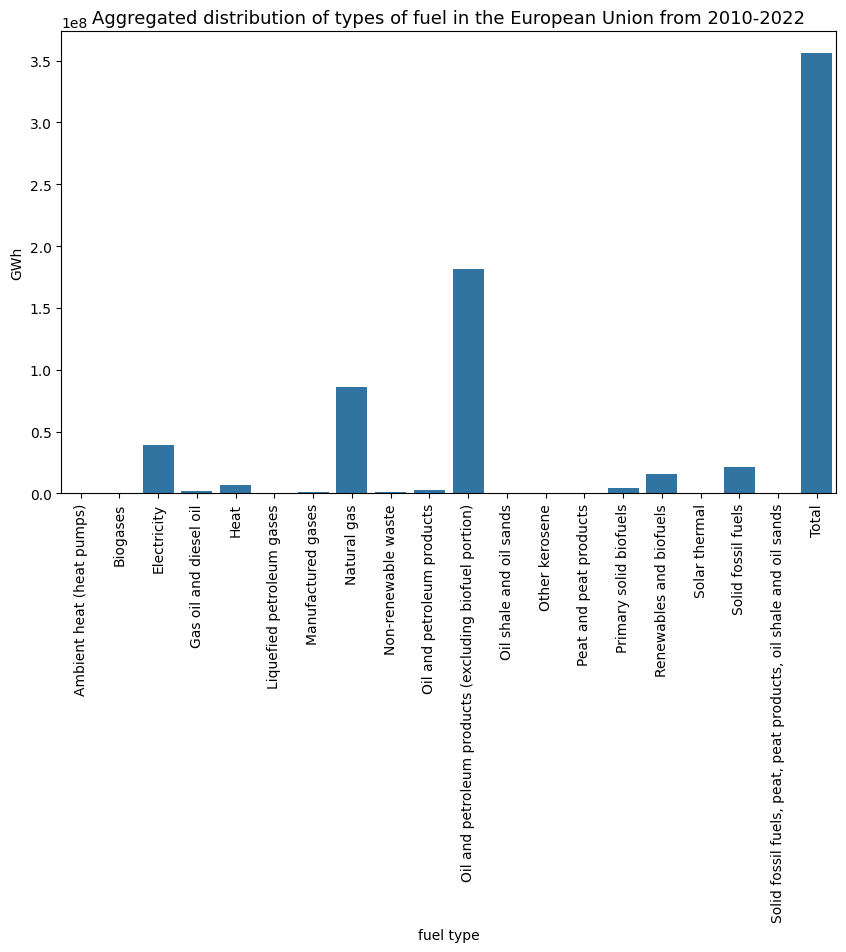

In [86]:
plt.figure(figsize=(10,6))
master_df_q1 = master_df.copy()
master_df_q1 = master_df_q1[master_df_q1.country_code == 'EU27_2020']
df_groups = master_df_q1.groupby(by='fuel').sum()
g = sns.barplot(data=df_groups, x=df_groups.index, y='gwh', errorbar=None)
g.set_title('Aggregated distribution of types of fuel in the European Union from 2010-2022', fontdict={'fontsize':13})
g.set_xlabel('fuel type')
g.set_ylabel('GWh')
plt.xticks(rotation=90)
plt.show()

For a first overview of the data, we can look at the barplot above, which shows the aggregated consumption for Households and Industry as well as Imports and Exports, divided by the type of fuel or the source of energy respectively for the years 2010 to 2022 in the European Union. The rightmost bar shows the total of all sources of energy combined. It can clearly be seen that oil and petroleum products make about 50% of all energy sources, while natural gas is in second place, which makes about 25% of the total. Solid fossil fuels however are in fourth place, making about 10% of the total. So from a first overview of the data, we can clearly see that fossil fuels are still highly in use in the European Union.

### Development of fossil fuel consumption

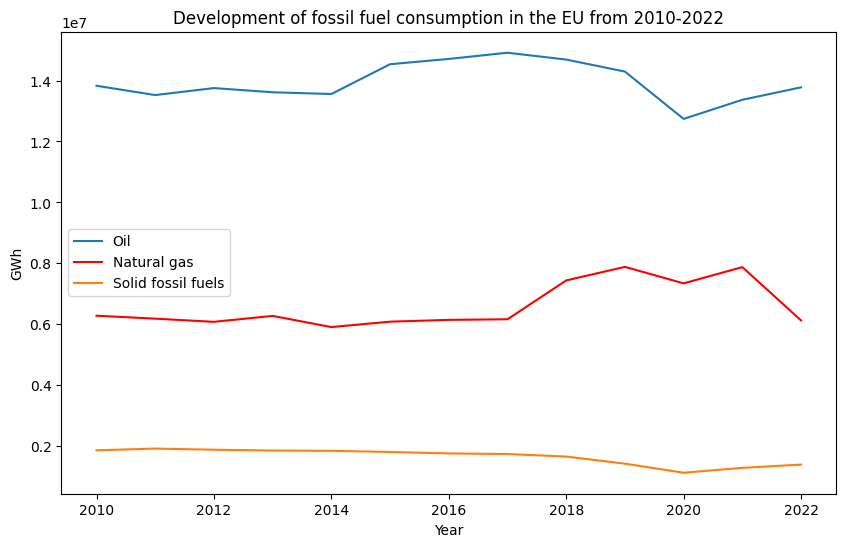

In [87]:
plt.figure(figsize=(10,6))
gp = master_df_q1.groupby(by=['fuel', 'year']).sum()
g = sns.lineplot(data=gp.loc[('Oil and petroleum products (excluding biofuel portion)')], x='year', y='gwh', label="Oil")
sns.lineplot(data = gp.loc[('Natural gas')], x='year', y='gwh', color='red', label="Natural gas")
sns.lineplot(data = gp.loc[('Solid fossil fuels')], x='year', y='gwh', label="Solid fossil fuels")
g.set(xticks=list(range(2010,2023, 2)), xlabel='Year', ylabel='GWh', title='Development of fossil fuel consumption in the EU from 2010-2022')
plt.show()

In this graph, we can see the aggregated consumption of oil, coal (=solid fossil fuels) and natural gas over the time period of 12 years between 2010 and 2022 in the EU. As we have seen already in the graph above, oil has the biggest share in the total of all used energy sources, and coal and gas have smaller shares. Over the time period of 12 years, the consumption has been quite steady for all three fuel types until the year 2020, where the curve nosedives especially for oil.

This nosedive could be correlated with the war that Russia has started against Ukraine in March of 2020, because of which the EU imposed sanctions on Russia and started to reduce its dependence on Russian fossil fuels.

It can also be observed that the consumption of coal stays steady throughout the years, with a small decrease around the year 2020. The consumption of natural gas however, seems to increase around the year 2017, but decrease again in 2021.

### Share of fossil fuels in Household & Industry

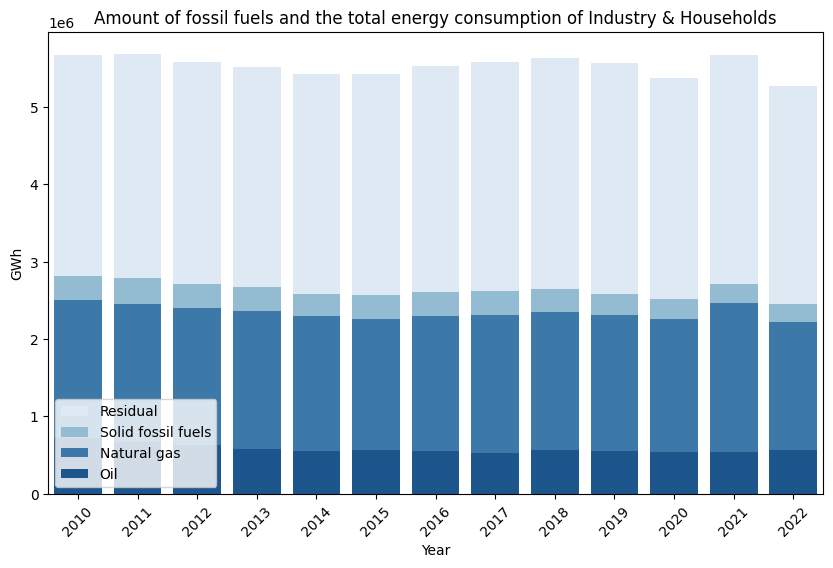

In [88]:
plt.figure(figsize=(10, 6))
total = master_df_q1[(master_df_q1.fuel == 'Total') 
                     & ((master_df_q1.sector =='Housholds')
                        |(master_df_q1.sector == 'Industry')
                       )]

oil = master_df_q1[(master_df_q1.fuel == 'Oil and petroleum products (excluding biofuel portion)')
                  & ((master_df_q1.sector=='Housholds')
                        |(master_df_q1.sector == 'Industry')
                    )]

coal = master_df_q1[(master_df_q1.fuel == 'Solid fossil fuels')
                   & ((master_df_q1.sector=='Housholds')
                        |(master_df_q1.sector == 'Industry')
                     )]

gas = master_df_q1[(master_df_q1.fuel == 'Natural gas')
                  & ((master_df_q1.sector=='Housholds')
                        |(master_df_q1.sector == 'Industry')
                    )]

fossil_fuels = pd.concat([oil, gas, coal])
oil_gas = pd.concat([oil, gas])

total_grouped = total.groupby('year').sum()
fossil_fuels_grouped= fossil_fuels.groupby('year').sum()
oil_gas_grouped = oil_gas.groupby('year').sum()
oil_grouped = oil.groupby('year').sum()
gas_grouped = gas.groupby('year').sum()
coal_grouped = coal.groupby('year').sum()

ax = sns.barplot(data=total_grouped, x=total_grouped.index, y='gwh', errorbar=None, color='#dbe9f6')
sns.barplot(data=fossil_fuels_grouped, x=fossil_fuels_grouped.index, y='gwh', errorbar=None, color='#89bedc')
sns.barplot(data=oil_gas_grouped, x=oil_gas_grouped.index, y='gwh', errorbar=None, color='#2b7bba')
sns.barplot(data=oil_grouped, x=oil_grouped.index, y='gwh', errorbar=None, color='#0b559f')

ax.set(xlabel='Year', ylabel='GWh', title='Amount of fossil fuels and the total energy consumption of Industry & Households')
plt.xticks(rotation=45)

plt.legend(labels=['Residual', 'Solid fossil fuels', 'Natural gas', 'Oil'], loc='lower left')

In the plot above, we can see the amount of Oil, Natural gas and solid fossil fuels as well as the rest of the energy sources combined in absolute numbers. We can see that the total energy consumption has been slightly reduced in the years from 2010-2022 and the share of fossil fuels has decreased as well, but for the exact percentages, we will look at the next plot.

In [89]:
plt.figure(figsize=(10, 6))

total_grouped['percent'] = [i / j * 100 for i,j in zip(total_grouped['gwh'], total_grouped['gwh'])]
fossil_fuels_grouped['percent'] = [i / j * 100 for i,j in zip(fossil_fuels_grouped['gwh'], total_grouped['gwh'])]
oil_gas_grouped['percent'] = [i / j * 100 for i,j in zip(oil_gas_grouped['gwh'], total_grouped['gwh'])]
oil_grouped['percent'] = [i / j * 100 for i,j in zip(oil_grouped['gwh'], total_grouped['gwh'])] 
gas_grouped['percent'] = [round(i / j * 100) for i,j in zip(gas_grouped['gwh'], total_grouped['gwh'])]
coal_grouped['percent'] = [round(i / j * 100) for i,j in zip(coal_grouped['gwh'], total_grouped['gwh'])]

coal_grouped['percent'] = coal_grouped['percent'].astype(str)
coal_grouped['percent'] = coal_grouped['percent'] + '%'

gas_grouped['percent'] = gas_grouped['percent'].astype(str)
gas_grouped['percent'] = gas_grouped['percent'] + '%'


ax=sns.barplot(data=total_grouped, x=total_grouped.index, y='percent', errorbar=None, color='#f6b48f')
sns.barplot(data=fossil_fuels_grouped, x=fossil_fuels_grouped.index, y='percent', errorbar=None, color='#f37651')
sns.barplot(data=oil_gas_grouped, x=oil_gas_grouped.index, y='percent', errorbar=None, color='#e13342')
sns.barplot(data=oil_grouped, x=oil_grouped.index, y='percent', errorbar=None, color='#ad1759')
for i in range(len(ax.containers)):
    if i==1:
        ax.bar_label(ax.containers[i], fmt='%.f%%', label_type='edge')
    elif i == 3:
        ax.bar_label(ax.containers[i], fmt='%.f%%', label_type='center')
    elif i == 2:
        ax.bar_label(ax.containers[i], fmt='%.f%%', label_type='center', labels=gas_grouped['percent'])
    if i == 2:
        ax.bar_label(ax.containers[i], fmt='%.f%%', label_type='edge', labels=coal_grouped['percent'])
ax.set(xlabel='Year', ylabel='Percentage', title='Proportion of fossil fuels of all energy sources of Industry & Households')
plt.xticks(rotation=45)

plt.legend(labels=['Residual', 'Solid fossil fuels', 'Natural gas', 'Oil'], loc='upper right')

In the percentage bar plot above, we can see that in Industry & Households, the share of fossil fuels decreased slightly over the past two decades. Starting from 2010, when the amount of oil, natural gas and solid fossil fuels combined made 50% of all energy sources of Industry and Households, the amount marginally decreased until 2022, when it was only 46%.

This shows that in Industry & Households, the efforts of the European Union to reduce the dependency on fossil fuels, first successes have become apparent (the share of fossil fuels could be reduced by 4% approximately), but there is still a long way to go.

We can also observe that the ratio between oil, solid fossil fuels and natural gas has not changed a lot over the past 12 years. We can see that the share of oil ranges between 9 and 13%. The share of natural gas stays quite steadily at about 32%, with only small fluctuations of 1-2% up or down. The share of solid fossil fuels is the smallest out of all fossil fuels in the Household and Industry sectors with a range from 6 down to 4% throughout the years 2010 to 2022. Overall, we can see that the share of both oil and solid fossil fuels have been reduced, leading to a reduction of the share of fossil fuels in total, while the share of gas has stayed the same in the considered time period.

### Conclusion

To conclude, we can say that fossil fuels are still in use in the European Union and the one with the highest share in the total amount of all energy sources combined are Oil and petroleum products (excluding biofuel), with natural gas being in second place and solid fossil fuels in fourth place after electricity. In the development of the consumption of fossil fuels in the EU over the considered time period 2010-2022 we could see that the amount of consumption is quite steady throughout the 12-year period, except for one nosedive, especially in the curve for oil, in the beginning of 2020, which could be correlated with the offensive war of Russia against Ukraine.

Regarding the share of fossil fuels in the sectors Household and Industry, it could be observed that the total amount of fossil fuels combined could be reduced by 4% from about 50% in 2010 to about 46% in 2022. While the share of natural gas has stayed quite steadily at around 32% of all energy sources, the share of oil was reduced by about 2% and the share of solid fossil fuels by around 2%.
So while we can see some first successes in reducing the dependency on fossil fuels in the European Union, the development is very slow and it is still a long way to reach the goal of being completely independent of fossil fuels.

## Question 2 (Stefan Helm)

What are the primary industrial and domestic uses of fossil and renewable fuels in European Union, and how have these usages
changed since 2010?

First we load our copy our master_df and filter on the sector Households and Industry, because those are the ones of interest of use. 
Furthermore we can kick out the rows where the usage is All, because we want to find out which usage is primalry responsible for the fossil/renewable energy use.
Similar for the fuel Total, because we want to group the fuels into renewables and fossil fuels for this analysis.

In [90]:
master_df_q2 = master_df_geo.copy()
master_df_q2 = master_df_q2[(master_df_q2['sector'].isin(['Households', 'Industry'])) & (master_df_q2['usage'] != 'All') & (master_df_q2['fuel'] != 'Total')]
master_df_q2.head()

usage             siec                fuel   
19149  Chemicals and petrochemicals  C0000X0350-0370  Solid fossil fuels  \
19150  Chemicals and petrochemicals  C0000X0350-0370  Solid fossil fuels   
19151  Chemicals and petrochemicals  C0000X0350-0370  Solid fossil fuels   
19152  Chemicals and petrochemicals  C0000X0350-0370  Solid fossil fuels   
19153  Chemicals and petrochemicals  C0000X0350-0370  Solid fossil fuels   

      country_code  year  gwh    sector  price_eur_per_gwh  country ISO2   
19149           AL  2010  0.0  Industry                NaN  Albania   AL  \
19150           AL  2011  0.0  Industry                NaN  Albania   AL   
19151           AL  2012  0.0  Industry                NaN  Albania   AL   
19152           AL  2013  0.0  Industry                NaN  Albania   AL   
19153           AL  2014  0.0  Industry                NaN  Albania   AL   

                                                geometry  
19149  POLYGON ((19.43621 41.02107, 19.45055 41.06000...  
19150  POLYGON ((19.43621 41.02107, 19.45055 41.06000...  
19151  POLYGON ((19.43621 41.02107, 19.45055 41.06000...  
19152  POLYGON ((19.43621 41.02107, 19.45055 41.06000...  
19153  POLYGON ((19.43621 41.02107, 19.45055 41.06000...

First we will divide our fuels into fossil and renewable fuels to filter the respective rows later on.

In [91]:
fossil_fuels_group = ['Solid fossil fuels', 'Manufactured gases', 'Natural gas',
                'Oil and petroleum products (excluding biofuel portion)',
                'Peat and peat products', 'Oil shale and oil sands',
                'Non-renewable waste', 'Liquefied natural gas',
                'Oil and petroleum products', 'Other kerosene',
                'Gas oil and diesel oil',
                'Solid fossil fuels, peat, peat products, oil shale and oil sands',
                'Liquefied petroleum gases']

renewable_fuels_group = ['Electricity', 'Heat', 'Nuclear heat', 'Renewables and biofuels',
                   'Primary solid biofuels', 'Biogases', 'Solar thermal',
                   'Ambient heat (heat pumps)']

We can now select the 27 European Union countries and aggregate them to see what are the primary usages and how those changed over time.
We do not use the EU Code because this only starts at 2018 for Households - to get more data we aggregate them by ourself.

In [92]:
fossil_usage = master_df_q2[master_df_q2['fuel'].isin(fossil_fuels_group)]
eu_fossil_usage = fossil_usage[fossil_usage['country'].isin(eu27_countries)].groupby(['year', 'fuel', 'usage', 'sector'])['gwh'].sum().reset_index()
agg_eu_fossil_usage = eu_fossil_usage.groupby(['year', 'usage', 'sector'])['gwh'].sum().reset_index()

In [93]:
renewable_usage = master_df_q2[master_df_q2['fuel'].isin(renewable_fuels_group)]
eu_renewable_usage = renewable_usage[renewable_usage['country'].isin(eu27_countries)].groupby(['year', 'fuel', 'usage', 'sector'])['gwh'].sum().reset_index()
agg_eu_renewable_usage = eu_renewable_usage.groupby(['year', 'usage', 'sector'])['gwh'].sum().reset_index()

In [94]:
countries_fossil_usage = fossil_usage[fossil_usage['country'].isin(eu27_countries)].groupby(['year', 'country', 'usage', 'sector', 'geometry'])['gwh'].sum().reset_index()
countries_renewable_usage = renewable_usage[renewable_usage['country'].isin(eu27_countries)].groupby(['year', 'country', 'usage', 'sector', 'geometry'])['gwh'].sum().reset_index()

### Industry

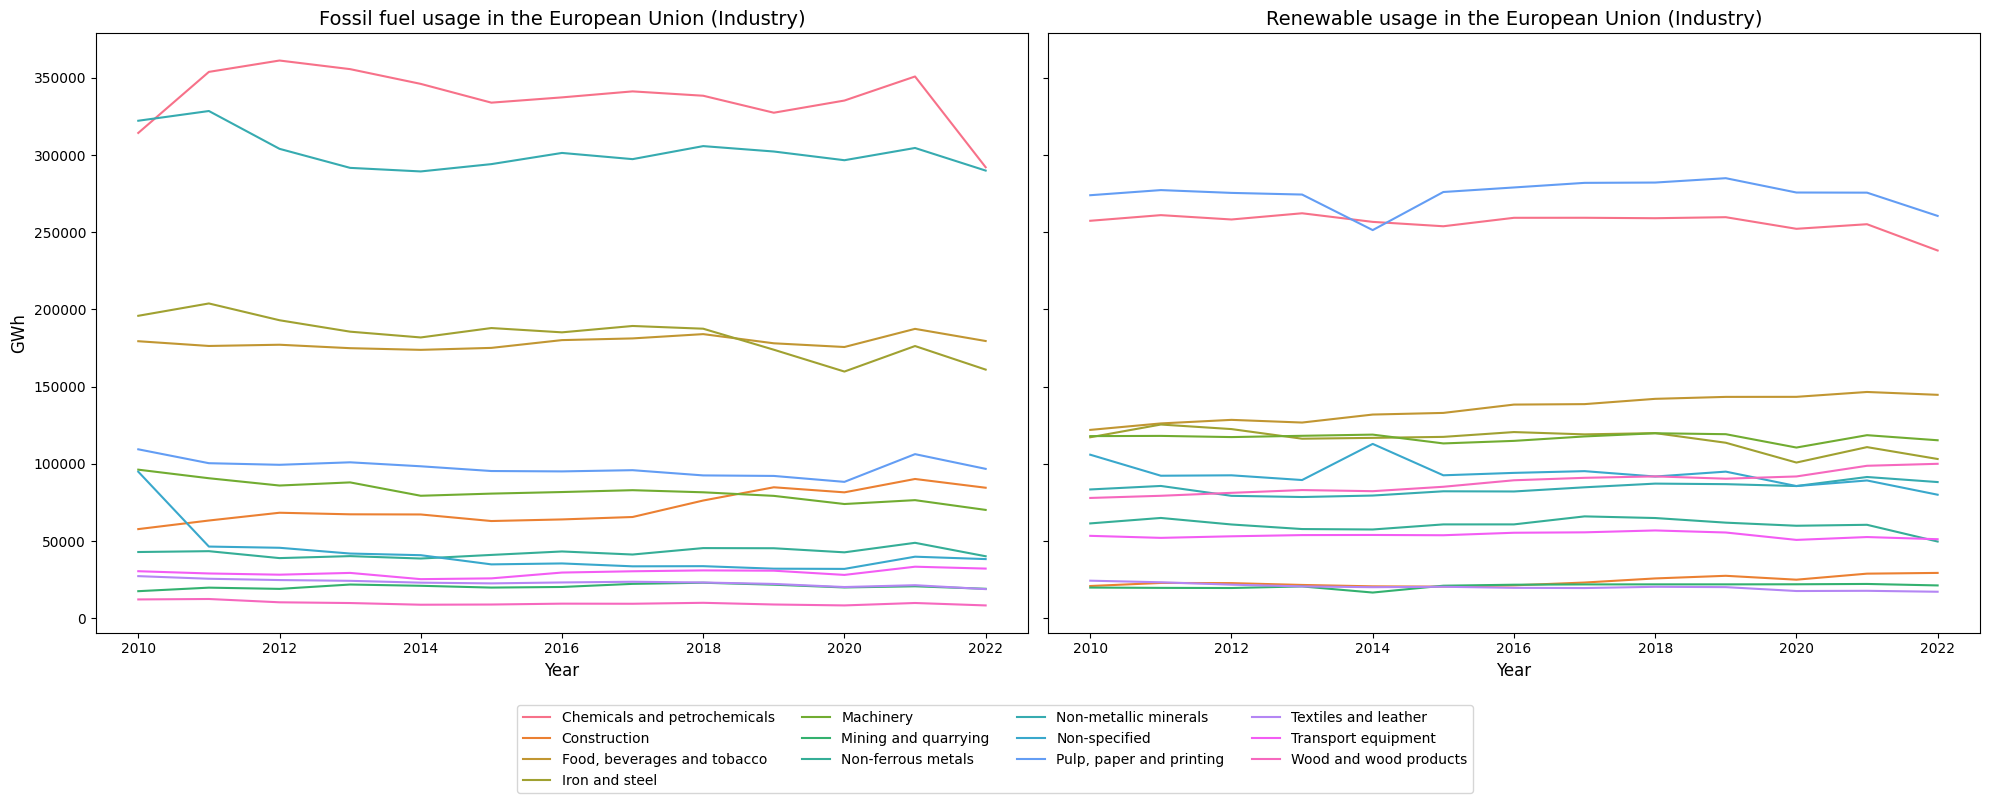

In [95]:
categories = agg_eu_renewable_usage[agg_eu_renewable_usage['sector'] == 'Industry']['usage'].unique()

# Create a custom color map as a dictionary
colors = sns.color_palette("husl", n_colors=len(categories))
color_map = dict(zip(categories, colors))

# Plot using the custom color map
fig, axs = plt.subplots(1, 2, figsize=(20, 7), sharey=True)

# Example usage in lineplot for fossil fuel usage
sns.lineplot(ax=axs[0], data=agg_eu_fossil_usage[agg_eu_fossil_usage['sector'] == 'Industry'], x='year', y='gwh', hue='usage', palette=color_map)
axs[0].set_title('Fossil fuel usage in the European Union (Industry)', fontsize=14)
axs[0].set_ylabel('GWh', fontsize=12)
axs[0].set_xlabel('Year', fontsize=12)
axs[0].get_legend().remove()

# Example usage in lineplot for renewable usage
sns.lineplot(ax=axs[1], data=agg_eu_renewable_usage[agg_eu_renewable_usage['sector'] == 'Industry'], x='year', y='gwh', hue='usage', palette=color_map)
axs[1].set_title('Renewable usage in the European Union (Industry)', fontsize=14)
axs[1].set_ylabel('GWh', fontsize=12)
axs[1].set_xlabel('Year', fontsize=12)
axs[1].get_legend().remove()

# Add legend for both plots manually in the bottom center
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.15))

plt.tight_layout()
plt.show()

In [96]:
agg_eu_fossil_usage[(agg_eu_fossil_usage['sector'] == 'Industry') & (agg_eu_fossil_usage['year'] == 2021)].sort_values(by='gwh', ascending=False).head(3)

year                         usage    sector         gwh
193  2021  Chemicals and petrochemicals  Industry  350821.568
201  2021         Non-metallic minerals  Industry  304540.176
196  2021   Food, beverages and tobacco  Industry  187398.683

In [97]:
agg_eu_renewable_usage[(agg_eu_renewable_usage['sector'] == 'Industry') & (agg_eu_renewable_usage['year'] == 2021)].sort_values(by='gwh', ascending=False).head(3)

year                         usage    sector         gwh
215  2021      Pulp, paper and printing  Industry  275607.641
203  2021  Chemicals and petrochemicals  Industry  255161.012
206  2021   Food, beverages and tobacco  Industry  146536.423

Analyzing fossil and renewable fuel usages in the European Union since 2010 reveals a stable overall volume across categories. 
In 2021, the top three fossil fuel usages were:
1. chemicals and petrochemicals
2. non-metallic minerals
3. food, beverages, and tobacco
This indicates a sustained demand in industrial sectors, emphasizing manufacturing and production. 

Meanwhile, the leading renewable fuel usages are:
1. pulp, paper, and printing
2. chemicals and petrochemicals
3. food, beverages, and tobacco 
This showcase a positive shift toward sustainability in specific industries.

Overall we can say that those four unique usages in the industry sector are the main usages. 

Moving forward, we will examine the fossil-renewable-energy ratio for these usages to understand how traditional and sustainable energy sources are balanced in the EU's industrial sector.

In [98]:
main_industry_usages = ['Chemicals and petrochemicals', 'Non-metallic minerals', 'Food, beverages and tobacco', 'Pulp, paper and printing']

top_industry_fossil = agg_eu_fossil_usage[(agg_eu_fossil_usage['sector'] == 'Industry') & (agg_eu_fossil_usage['year'] == 2021) & (agg_eu_fossil_usage['usage'].isin(main_industry_usages))]
top_industry_fossil['fuel'] = 'Fossil'
top_industry_rewnable = agg_eu_renewable_usage[(agg_eu_renewable_usage['sector'] == 'Industry') & (agg_eu_renewable_usage['year'] == 2021) & (agg_eu_renewable_usage['usage'].isin(main_industry_usages))]
top_industry_rewnable['fuel'] = 'Renewable'

top_industry_usage = pd.concat([top_industry_fossil, top_industry_rewnable], ignore_index=True)

# Claculate the ratio for each usage between fossil and renewable
top_industry_usage['ratio'] = top_industry_usage['gwh'] / top_industry_usage.groupby(['usage'])['gwh'].transform('sum')

/var/folders/9b/ztby2vp10jxgc26kbjm6slr80000gn/T/ipykernel_73540/1853639521.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_industry_fossil['fuel'] = 'Fossil'
/var/folders/9b/ztby2vp10jxgc26kbjm6slr80000gn/T/ipykernel_73540/1853639521.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_industry_rewnable['fuel'] = 'Renewable'


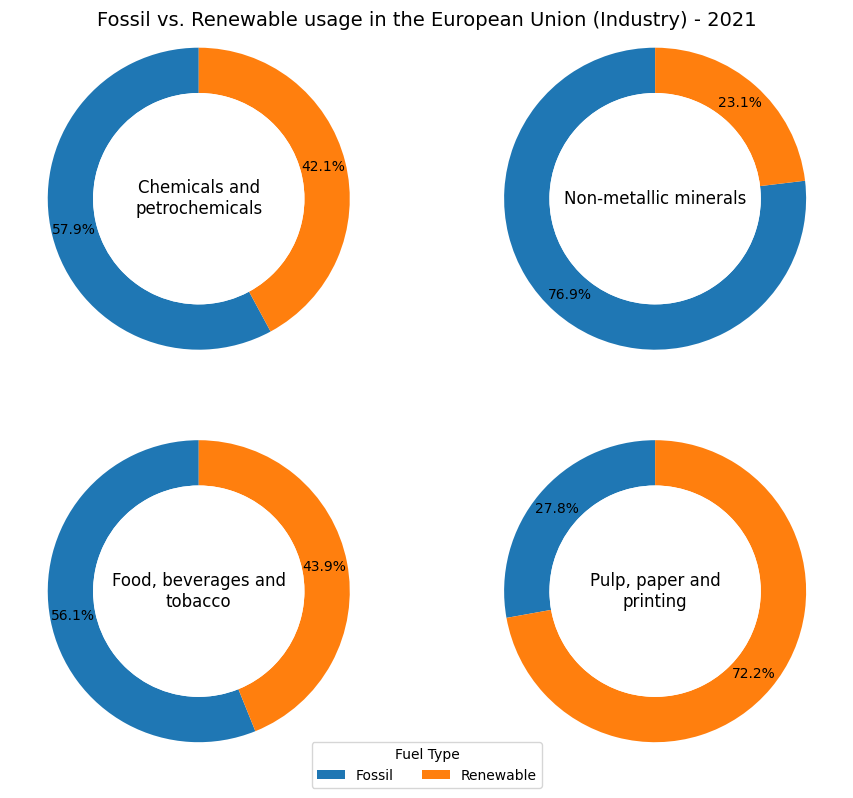

In [99]:
# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Iterate through usages and create donut chart for each
for i, usage in enumerate(main_industry_usages):
    ax = axs[i // 2, i % 2]
    
    # Filter data for the specific usage
    usage_data = top_industry_usage[top_industry_usage['usage'] == usage]
    
     # Extract fossil and renewable ratios
    fossil_ratio = usage_data[usage_data['fuel'] == 'Fossil']['ratio'].values[0]
    renewable_ratio = usage_data[usage_data['fuel'] == 'Renewable']['ratio'].values[0]
    
    # Create labels and values for the donut chart
    labels = ['Fossil', 'Renewable']
    sizes = [fossil_ratio, renewable_ratio]
    
    # Plot the donut chart
    wedges, texts, autotexts = ax.pie(sizes, autopct='%1.1f%%', startangle=90, pctdistance=0.85, wedgeprops=dict(width=0.3))
    
    # Draw a circle at the center to create a donut chart
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    ax.add_patch(centre_circle)

    #shift autoexts more to the outside
    for autotext in autotexts:
        autotext.set_horizontalalignment('center')
        autotext.set_verticalalignment('center')
    
    #add text in the center
    usage_text = usage.replace(' and ', ' and\n')
    ax.text(0, 0, usage_text, horizontalalignment='center', verticalalignment='center', fontsize=12)
        
    # Remove labels
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
# add one legend at the bottom for all plots
fig.legend(wedges, labels, loc='lower center', title="Fuel Type", ncol=2, bbox_to_anchor=(0.5, 0))

## add titel
fig.suptitle('Fossil vs. Renewable usage in the European Union (Industry) - 2021', fontsize=14)

# Show the plot
plt.show()


Notably, the chemical and petrochemical sector exhibits a diverse energy mix, with a fossil fuel ratio of 57.9% and a renewable energy ratio of 42.1%. This suggests a concerted effort in incorporating renewable energy sources but also underscores the significant reliance on fossil fuels within this sector.

In contrast, the food, beverages, and tobacco industry leans towards a more balanced energy profile, with fossil and renewable energy ratios of 56.1% and 43.8%, respectively. This sector's commitment to a substantial share of renewable energy signifies a positive trend towards sustainability, although fossil fuels still play a considerable role.

The non-metallic minerals industry displays a higher reliance on fossil fuels, with a fossil fuel ratio of 76.9% and a renewable energy ratio of 23.1%. This indicates a potential area for improvement in transitioning towards cleaner energy sources.

On the other hand, the pulp, paper, and printing sector showcase a noteworthy commitment to renewable energy, boasting a fossil fuel ratio of 27.8% and a renewable energy ratio of 72.2%. This sector's proactive adoption of renewable sources aligns with the broader EU goals for sustainability.

The fossil-renewable-energy ratio analysis emphasizes the need for continued efforts to reduce reliance on fossil fuels, especially in sectors like non-metallic minerals, while acknowledging the progress made in industries such as pulp, paper, and printing.

Now we will also check the georaphical location of those usages.

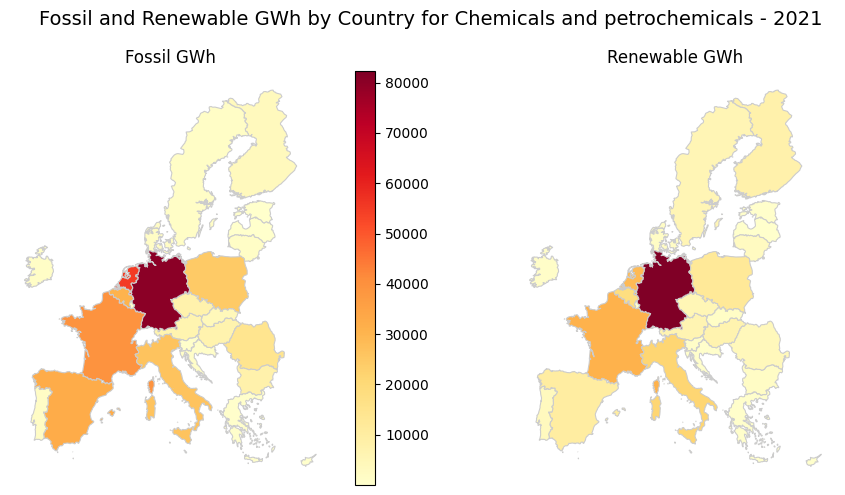

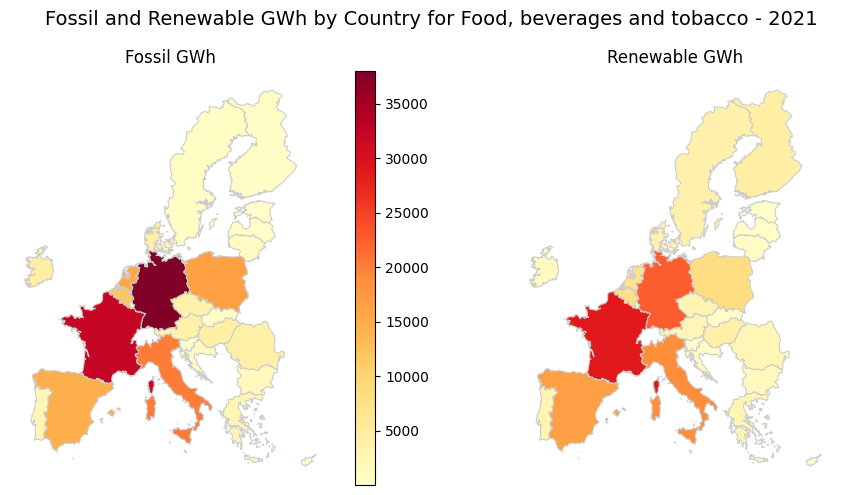

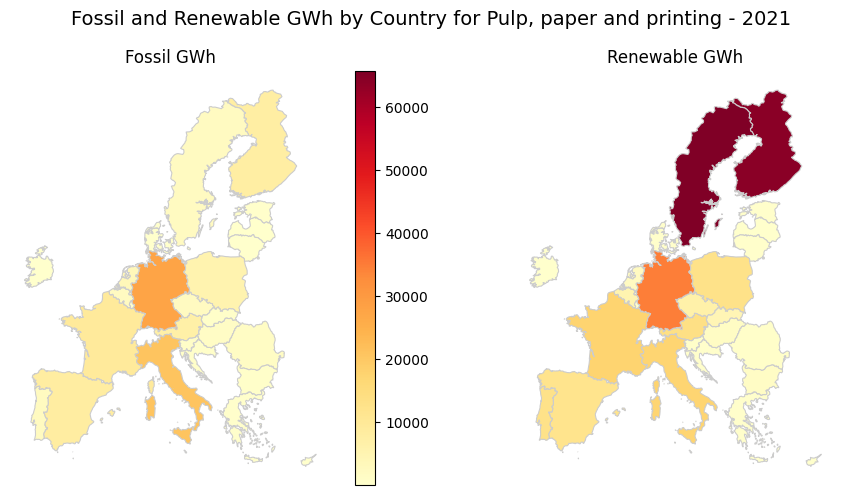

In [100]:
fossil_industry_2021 = countries_fossil_usage[(countries_fossil_usage['year'] == 2021) & (countries_fossil_usage['sector'] == 'Industry')]
renewable_industry_2021 = countries_renewable_usage[(countries_renewable_usage['year'] == 2021) & (countries_renewable_usage['sector'] == 'Industry')]

fossil_industry_2021 = gpd.GeoDataFrame(fossil_industry_2021, geometry='geometry')
renewable_industry_2021 = gpd.GeoDataFrame(renewable_industry_2021, geometry='geometry')

for usage in main_industry_usages:
    #select the usage
    fossil_usage = fossil_industry_2021[fossil_industry_2021['usage'] == usage]
    renewable_usage = renewable_industry_2021[renewable_industry_2021['usage'] == usage]

    # Get the minimum and maximum values for 'gwh' in both GeoDataFrames
    min_value = min(fossil_usage['gwh'].min(), renewable_usage['gwh'].min())
    max_value = max(fossil_usage['gwh'].max(), renewable_usage['gwh'].max())

    # Set up subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the first map
    fossil_usage.plot(column='gwh', cmap='YlOrRd', linewidth=0.8, ax=axs[0], edgecolor='0.8', legend=True, vmin=min_value, vmax=max_value)
    axs[0].set_title('Fossil GWh')
    axs[0].axis('off')


    # Plot the second map
    renewable_usage.plot(column='gwh', cmap='YlOrRd', linewidth=0.8, ax=axs[1], edgecolor='0.8', legend=False, vmin=min_value, vmax=max_value)
    axs[1].set_title('Renewable GWh')
    axs[1].axis('off')


    # Add a title to the figure
    fig.suptitle(f'Fossil and Renewable GWh by Country for {usage} - 2021', fontsize=14)

    plt.tight_layout()
    plt.show()

The geoheatmap analysis of industrial energy usage across different sectors in the European Union for both fossil and renewable fuels provides valuable insights into regional patterns. Focusing on the chemicals and petrochemicals sector, it is notable that Germany emerges as a prominent contributor to both fossil and renewable energy usage. However, the southern countries, particularly Spain and France, exhibit a higher reliance on fossil fuels, with Belgium demonstrating the most substantial disparity between fossil and renewable usage.

Similar patterns are observed in the Non-Metallic Minerals industry, where Germany, Italy, Spain, France, and Poland stand out as major contributors to both fossil and renewable energy consumption. The contrast is particularly pronounced, emphasizing the challenges these countries may face in transitioning towards a more sustainable energy mix.

In the Food, Beverages, and Tobacco sector, the geoheatmap reflects a more balanced distribution, with significant contributions from Germany and France. This suggests a collective effort within these countries to maintain equilibrium between fossil and renewable energy sources.

For the Pulp, Paper, and Printing sector, Sweden and Finland emerge as leaders in embracing renewable energy sources, showcasing a stark contrast to other European nations. Their high renewable energy ratios underscore a commitment to sustainable practices within this sector.

In a broader context, Finland and Sweden consistently exhibit high renewable energy ratios across various industries, reinforcing their position as leaders in sustainable energy adoption. Overall, these geoheatmap findings highlight both regional disparities and notable exceptions, offering valuable insights for policymakers and industry stakeholders seeking to navigate the transition towards cleaner and more sustainable energy sources within the European Union.

### Households

In [101]:
categories = agg_eu_renewable_usage[agg_eu_renewable_usage['sector'] == 'Households']['usage'].unique()

# Create a custom color map as a dictionary
colors = sns.color_palette("husl", n_colors=len(categories))
color_map = dict(zip(categories, colors))

# Plot using the custom color map
fig, axs = plt.subplots(1, 2, figsize=(20, 7), sharey=True)

# Example usage in lineplot for fossil fuel usage
sns.lineplot(ax=axs[0], data=agg_eu_fossil_usage[agg_eu_fossil_usage['sector'] == 'Households'], x='year', y='gwh', hue='usage', palette=color_map)
axs[0].set_title('Fossil fuel usage in the European Union (Households)', fontsize=14)
axs[0].set_ylabel('GWh', fontsize=12)
axs[0].set_xlabel('Year', fontsize=12)
axs[0].get_legend().remove()

# Example usage in lineplot for renewable usage
sns.lineplot(ax=axs[1], data=agg_eu_renewable_usage[agg_eu_renewable_usage['sector'] == 'Households'], x='year', y='gwh', hue='usage', palette=color_map)
axs[1].set_title('Renewable usage in the European Union (Households)', fontsize=14)
axs[1].set_ylabel('GWh', fontsize=12)
axs[1].set_xlabel('Year', fontsize=12)
axs[1].get_legend().remove()

# Add legend for both plots manually in the bottom center
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.15))

plt.tight_layout()
plt.show()

In [102]:
agg_eu_fossil_usage[(agg_eu_fossil_usage['sector'] == 'Households') & (agg_eu_fossil_usage['year'] == 2021)].sort_values(by='gwh', ascending=False).head(3)

year          usage      sector           gwh
206  2021  Space heating  Households  1.256306e+06
209  2021  Water heating  Households  2.642884e+05
195  2021        Cooking  Households  8.118679e+04

In [103]:
agg_eu_renewable_usage[(agg_eu_renewable_usage['sector'] == 'Households') & (agg_eu_renewable_usage['year'] == 2021)].sort_values(by='gwh', ascending=False).head(3)

year          usage      sector           gwh
217  2021  Space heating  Households  1.466608e+06
208  2021       Lighting  Households  4.147003e+05
220  2021  Water heating  Households  2.652515e+05

Analyzing household energy consumption in the European Union reveals a stable overall volume since 2010. In 2021, the top three fossil fuel usages were:

1. Space heating
2. Water heating
3. Cooking
These categories indicate a sustained demand for fossil fuels in essential household functions, emphasizing heating and cooking applications. Conversely, the leading renewable fuel usages for households in 2021 were:

1. Space heating
2. Lighting
3. Water heating
This shift towards renewable sources, particularly in space heating, suggests an increasing adoption of sustainable energy practices. While usage patterns remain consistent across both fuel types, there was a notable upward movement around 2015, with space heating exhibiting more fluctuation. Since 2015, there has been a constant rise in renewable energy usage for space heating, signaling a progressive transition towards cleaner energy sources in meeting household needs. This analysis sets the stage for a detailed examination of the fossil-renewable-energy ratio, providing insights into the balance between traditional and sustainable energy sources within EU households.



In [104]:
main_households_usages = ['Space heating', 'Water heating', 'Cooking', 'Lighting']

top_households_fossil = agg_eu_fossil_usage[(agg_eu_fossil_usage['sector'] == 'Households') & (agg_eu_fossil_usage['year'] == 2021) & (agg_eu_fossil_usage['usage'].isin(main_households_usages))]
top_households_fossil['fuel'] = 'Fossil'
#add row Lighting for Fossil with 0 gwh to make the dataframe symmetric
top_households_fossil = pd.concat([top_households_fossil, pd.DataFrame([[2021, 'Lighting', 'Households', 'Fossil', 0]], columns=['year', 'usage', 'sector', 'fuel', 'gwh'])], ignore_index=True)

top_households_rewnable = agg_eu_renewable_usage[(agg_eu_renewable_usage['sector'] == 'Households') & (agg_eu_renewable_usage['year'] == 2021) & (agg_eu_renewable_usage['usage'].isin(main_households_usages))]
top_households_rewnable['fuel'] = 'Renewable'

top_households_usage = pd.concat([top_households_fossil, top_households_rewnable], ignore_index=True)

# Claculate the ratio for each usage between fossil and renewable
top_households_usage['ratio'] = top_households_usage['gwh'] / top_households_usage.groupby(['usage'])['gwh'].transform('sum')


/var/folders/9b/ztby2vp10jxgc26kbjm6slr80000gn/T/ipykernel_73540/3927333579.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_households_fossil['fuel'] = 'Fossil'
/var/folders/9b/ztby2vp10jxgc26kbjm6slr80000gn/T/ipykernel_73540/3927333579.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_households_rewnable['fuel'] = 'Renewable'


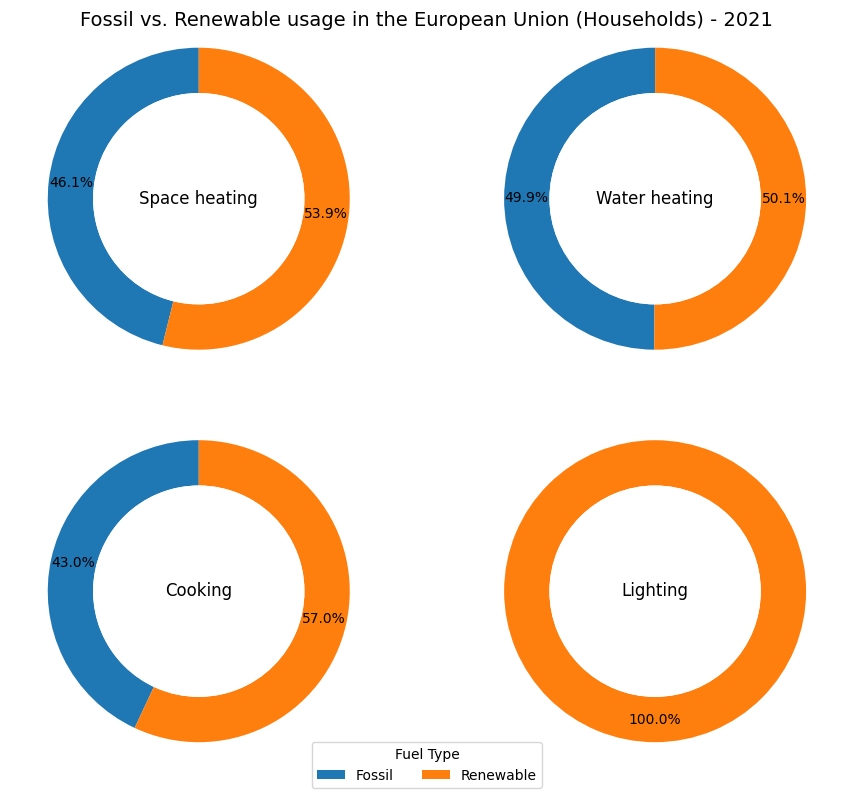

In [105]:
# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Iterate through usages and create donut chart for each
for i, usage in enumerate(main_households_usages):
    ax = axs[i // 2, i % 2]
    
    # Filter data for the specific usage
    usage_data = top_households_usage[top_households_usage['usage'] == usage]
    
     # Extract fossil and renewable ratios
    fossil_ratio = usage_data[usage_data['fuel'] == 'Fossil']['ratio'].values[0]
    renewable_ratio = usage_data[usage_data['fuel'] == 'Renewable']['ratio'].values[0]
    
    # Create labels and values for the donut chart
    labels = ['Fossil', 'Renewable']
    sizes = [fossil_ratio, renewable_ratio]
    
    # Plot the donut chart
    wedges, texts, autotexts = ax.pie(sizes, autopct='%1.1f%%', startangle=90, pctdistance=0.85, wedgeprops=dict(width=0.3))
    
    # Draw a circle at the center to create a donut chart
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    ax.add_patch(centre_circle)

    #shift autoexts more to the outside
    for autotext in autotexts:
        autotext.set_horizontalalignment('center')
        autotext.set_verticalalignment('center')

        #del autotexts if the value is 0.0
        if autotext.get_text() == '0.0%':
            autotext.set_text('')
    
    #add text in the center
    usage_text = usage.replace(' and ', ' and\n')
    ax.text(0, 0, usage_text, horizontalalignment='center', verticalalignment='center', fontsize=12)
        
    # Remove labels
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
# add one legend at the bottom for all plots
fig.legend(wedges, labels, loc='lower center', title="Fuel Type", ncol=2, bbox_to_anchor=(0.5, 0))

## add titel
fig.suptitle('Fossil vs. Renewable usage in the European Union (Households) - 2021', fontsize=14)

# Show the plot
plt.show()

**Cooking:** In 2021, the household sector witnessed a noteworthy transition in cooking energy sources. The fossil fuel ratio for cooking stood at 43.0%, while the renewable ratio reached 56.9%. This shift indicates a substantial move towards sustainable energy options, with more than half of the energy used for cooking derived from renewable sources.

**Space Heating:** For space heating in households, the distribution between fossil and renewable sources in 2021 was fairly balanced. The fossil fuel ratio amounted to 46.1%, while the renewable ratio reached 53.9%. This suggests a significant contribution from sustainable energy in meeting the heating needs of households.

**Water Heating:** In the water heating sector, there was a nearly equal split between fossil and renewable energy sources in 2021. The fossil fuel ratio reached 49.9%, while the renewable ratio stood at 50.1%. This balanced distribution highlights a substantial shift towards sustainability in the energy mix for water heating applications.

**Lighting:** In the realm of household energy consumption, the category of lighting revealed an unsurprising yet significant aspect. In 2021, lighting was entirely dependent on renewable energy sources, boasting a fossil fuel ratio of 0.0% and a renewable ratio of 100.0%. However, this achievement is largely attributed to the fact that lighting predominantly utilizes electricity, which is inherently associated with renewable sources.

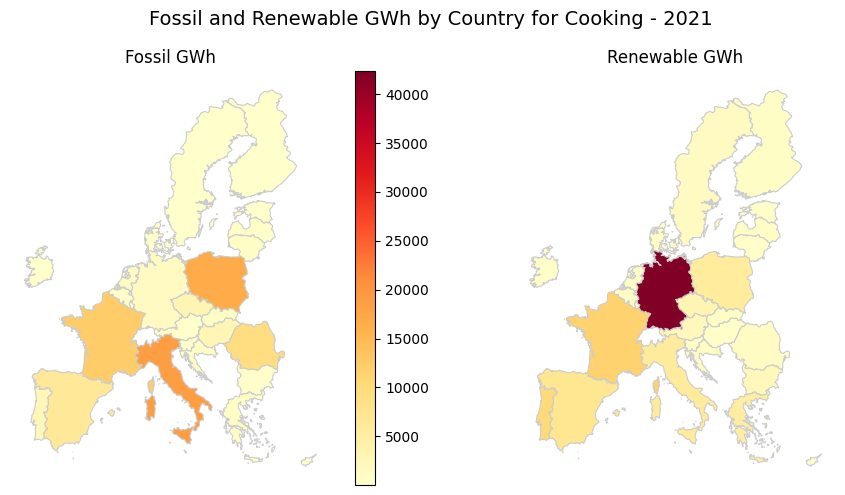

In [106]:
fossil_households_2021 = countries_fossil_usage[(countries_fossil_usage['year'] == 2021) & (countries_fossil_usage['sector'] == 'Households')]
renewable_households_2021 = countries_renewable_usage[(countries_renewable_usage['year'] == 2021) & (countries_renewable_usage['sector'] == 'Households')]

fossil_households_2021 = gpd.GeoDataFrame(fossil_households_2021, geometry='geometry')
renewable_households_2021 = gpd.GeoDataFrame(renewable_households_2021, geometry='geometry')

for usage in main_households_usages:
    if usage == 'Lighting':
        continue
    #select the usage
    fossil_usage = fossil_households_2021[fossil_households_2021['usage'] == usage]
    renewable_usage = renewable_households_2021[renewable_households_2021['usage'] == usage]

    # Get the minimum and maximum values for 'gwh' in both GeoDataFrames
    min_value = min(fossil_usage['gwh'].min(), renewable_usage['gwh'].min())
    max_value = max(fossil_usage['gwh'].max(), renewable_usage['gwh'].max())

    # Set up subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the first map
    fossil_usage.plot(column='gwh', cmap='YlOrRd', linewidth=0.8, ax=axs[0], edgecolor='0.8', legend=True, vmin=min_value, vmax=max_value)
    axs[0].set_title('Fossil GWh')
    axs[0].axis('off')


    # Plot the second map
    renewable_usage.plot(column='gwh', cmap='YlOrRd', linewidth=0.8, ax=axs[1], edgecolor='0.8', legend=False, vmin=min_value, vmax=max_value)
    axs[1].set_title('Renewable GWh')
    axs[1].axis('off')


    # Add a title to the figure
    fig.suptitle(f'Fossil and Renewable GWh by Country for {usage} - 2021', fontsize=14)

    plt.tight_layout()
    plt.show()

The geoheatmap analysis of household energy consumption across the European Union identifies Germany, France, Italy, and Poland as the primary contributors to overall energy usage. Notable patterns emerge when examining specific usage categories.

**Renewable Space Heating:** France and Poland demonstrate a more substantial reliance on renewable sources for space heating compared to their consumption of fossil fuels. This suggests a commendable commitment in these countries to adopting sustainable practices in meeting space heating needs.

**Renewable Water Heating:** Similar to space heating, France and Poland exhibit a higher share in renewable energy usage for water heating. This underscores a notable transition towards renewable sources to fulfill water heating requirements in these countries.

**Cooking:** In the context of cooking, Italy and Poland stand out for their significant consumption of fossil fuels, indicating a prevalent use of gas ovens. Conversely, Germany shows a concentrated effort in utilizing renewable sources for cooking, highlighting a positive trend towards sustainable cooking practices.

The distinct regional variations in the adoption of renewable energy sources for specific usage categories underscore the nuanced approaches taken by different countries in addressing their energy needs and aligning with broader sustainability goals.

### Conclusion 

The analysis of European Union energy usage since 2010 indicates stable patterns in both industrial and household sectors. In 2021, key fossil fuel consumption in industries centered around chemicals and petrochemicals, non-metallic minerals, and food, beverages, and tobacco, while leading renewable usage occurred in pulp, paper, and printing, chemicals and petrochemicals, and food, beverages, and tobacco. The fossil-renewable energy ratio underscores diverse industry energy mixes, with challenges in reducing fossil fuel reliance, notably in sectors like non-metallic minerals. Germany stands out in geographical analysis, making a significant contribution to both fossil and renewable industry consumption.

In households, overall energy consumption has remained stable since 2010. Top fossil fuel usages in 2021 include space heating, water heating, and cooking, highlighting persistent demand for fossil fuels. However, there is a growing adoption of sustainable energy practices, with renewable usage increasing in space heating, lighting, and water heating. The fossil-renewable energy ratio analysis reveals a notable shift towards sustainability, particularly in cooking, space heating, and water heating. Geoheatmap findings for 2021 identify France, Germany, Italy, and Poland as major contributors to renewable household energy, showcasing distinct regional variations in adopting renewable sources for specific needs. Overall, there is a trend towards increased use of renewable energy in both industrial and household sectors, though challenges persist in reducing fossil fuel reliance.

### Create Plot for Management Summary

In [107]:
top_usages = pd.concat([top_households_usage, top_industry_usage], ignore_index=True)

#add total gwh for each usage 
top_usages['total_gwh'] = top_usages.groupby(['usage'])['gwh'].transform('sum')

#order by total gwh
top_usages = top_usages.sort_values(by='total_gwh', ascending=False)

#top 2 household and industry usages (total 4 usages)
top_house_ind_usage = ['Space heating', 'Water heating', 'Chemicals and petrochemicals', 'Non-metallic minerals']

# Create a 2x2 subplot
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Iterate through usages and create donut chart for each
for i, usage in enumerate(top_house_ind_usage):
    ax = axs[i]
    
    # Filter data for the specific usage
    usage_data = top_usages[top_usages['usage'] == usage]
    
     # Extract fossil and renewable ratios
    fossil_ratio = usage_data[usage_data['fuel'] == 'Fossil']['ratio'].values[0]
    renewable_ratio = usage_data[usage_data['fuel'] == 'Renewable']['ratio'].values[0]
    
    # Create labels and values for the donut chart
    labels = ['Fossil', 'Renewable']
    sizes = [fossil_ratio, renewable_ratio]
    
    # Plot the donut chart
    wedges, texts, autotexts = ax.pie(sizes, autopct='%1.1f%%', startangle=90, pctdistance=0.85, wedgeprops=dict(width=0.3))
    
    # Draw a circle at the center to create a donut chart
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    ax.add_patch(centre_circle)

    #add text in the center
    usage_text = usage.replace(' and ', ' and\n')
    total_twh = round(usage_data['total_gwh'].values[0]/1000,1)
    ax.text(0, 0, f"{usage_data['sector'].values[0]}\n{usage_text}\n{total_twh} TWh", horizontalalignment='center', verticalalignment='center', fontsize=12)
        
    # Remove labels
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
# add one legend at the bottom for all plots
fig.legend(wedges, labels, loc='lower center', title="Fuel Type", ncol=2, bbox_to_anchor=(0.5, 0))

## add titel
fig.suptitle('Fossil-Renewable-Ratio for usages in the European Union - 2021', fontsize=14)

# Show the plot
plt.show()


## Question 3 (Thomas Laner)

How do fluctuations in electricity and natural gas prices, affect the consumption of these goods (correlation, other influences)? How do they affect the share of renewable energy in gross final energy consumption?

First we can print the master_df which contain the prices over different years of different product and customer-types, as well as their consumption rates. Hereby, we firstly filter for the full EU27 country code as well as the sector 'Industry'.

In [108]:
# copy the master_df to adjust it for the question
df_q3 = master_df.copy()

#select only EU27_2020, Households and Industry
df_q3 = df_q3[(df_q3['country_code'] == 'EU27_2020') & (df_q3['sector'].isin(['Households', 'Industry'])) & (df_q3['usage'] == 'All')]

#rename the Oil columns for Households and Industry to the same name
df_q3.loc[df_q3['fuel'] == 'Oil and petroleum products (excluding biofuel portion)', 'fuel'] = 'Oil and petroleum products'

#filter for Electricity, Natural Gas and Oil and petroleum products
df_q3 = df_q3[df_q3['fuel'].isin(['Electricity', 'Natural gas', 'Oil and petroleum products'])]

#select only the rows where gwh and price_eur_per_gwh are not null
df_q3 = df_q3[~df_q3['gwh'].isnull() & ~df_q3['price_eur_per_gwh'].isnull()]

#delete the usage and siec columns
df_q3.drop(['usage', 'siec'], axis=1, inplace=True)

#print the shape
display(df_q3)

fuel country_code  year           gwh   
13992                  Electricity    EU27_2020  2014  9.101032e+05  \
13993                  Electricity    EU27_2020  2015  9.138667e+05   
13994                  Electricity    EU27_2020  2016  9.258933e+05   
13995                  Electricity    EU27_2020  2017  9.423863e+05   
13996                  Electricity    EU27_2020  2018  9.454368e+05   
13997                  Electricity    EU27_2020  2019  9.329229e+05   
13998                  Electricity    EU27_2020  2020  8.850574e+05   
13999                  Electricity    EU27_2020  2021  9.296308e+05   
14000                  Electricity    EU27_2020  2022  8.759238e+05   
14525                  Natural gas    EU27_2020  2014  8.660540e+05   
14526                  Natural gas    EU27_2020  2015  8.454020e+05   
14527                  Natural gas    EU27_2020  2016  8.717663e+05   
14528                  Natural gas    EU27_2020  2017  8.943080e+05   
14529                  Natural gas    EU27_2020  2018  8.913530e+05   
14530                  Natural gas    EU27_2020  2019  8.819004e+05   
14531                  Natural gas    EU27_2020  2020  8.625608e+05   
14532                  Natural gas    EU27_2020  2021  9.569889e+05   
14533                  Natural gas    EU27_2020  2022  8.223257e+05   
16112   Oil and petroleum products    EU27_2020  2015  2.861823e+05   
16113   Oil and petroleum products    EU27_2020  2016  2.796850e+05   
16114   Oil and petroleum products    EU27_2020  2017  2.638430e+05   
16115   Oil and petroleum products    EU27_2020  2018  2.842094e+05   
16116   Oil and petroleum products    EU27_2020  2019  2.742530e+05   
16117   Oil and petroleum products    EU27_2020  2020  2.687565e+05   
16118   Oil and petroleum products    EU27_2020  2021  2.731191e+05   
16119   Oil and petroleum products    EU27_2020  2022  2.849684e+05   
119417                 Electricity    EU27_2020  2018  7.061015e+05   
119678                 Natural gas    EU27_2020  2018  9.354801e+05   
119754  Oil and petroleum products    EU27_2020  2018  3.287733e+05   
121885                 Electricity    EU27_2020  2019  7.040122e+05   
122146                 Natural gas    EU27_2020  2019  9.255897e+05   
122222  Oil and petroleum products    EU27_2020  2019  3.379721e+05   
124353                 Electricity    EU27_2020  2020  7.115883e+05   
124614                 Natural gas    EU27_2020  2020  9.134657e+05   
124690  Oil and petroleum products    EU27_2020  2020  3.541033e+05   
126821                 Electricity    EU27_2020  2021  7.474027e+05   
127082                 Natural gas    EU27_2020  2021  1.019494e+06   
127158  Oil and petroleum products    EU27_2020  2021  2.896355e+05   

            sector  price_eur_per_gwh         country  
13992     Industry       8.860000e+04  European Union  
13993     Industry       8.420000e+04  European Union  
13994     Industry       7.930000e+04  European Union  
13995     Industry       7.670000e+04  European Union  
13996     Industry       7.790000e+04  European Union  
13997     Industry       8.420000e+04  European Union  
13998     Industry       8.170000e+04  European Union  
13999     Industry       8.590000e+04  European Union  
14000     Industry       1.604000e+05  European Union  
14525     Industry       3.605292e+04  European Union  
14526     Industry       3.300552e+04  European Union  
14527     Industry       2.755620e+04  European Union  
14528     Industry       2.584548e+04  European Union  
14529     Industry       2.661408e+04  European Union  
14530     Industry       2.836836e+04  European Union  
14531     Industry       2.489004e+04  European Union  
14532     Industry       2.383632e+04  European Union  
14533     Industry       5.898312e+04  European Union  
16112     Industry       1.159016e+07  European Union  
16113     Industry       1.063853e+07  European Union  
16114     Industry       1.174981e+07  European Union  
16115     Industry       1.3

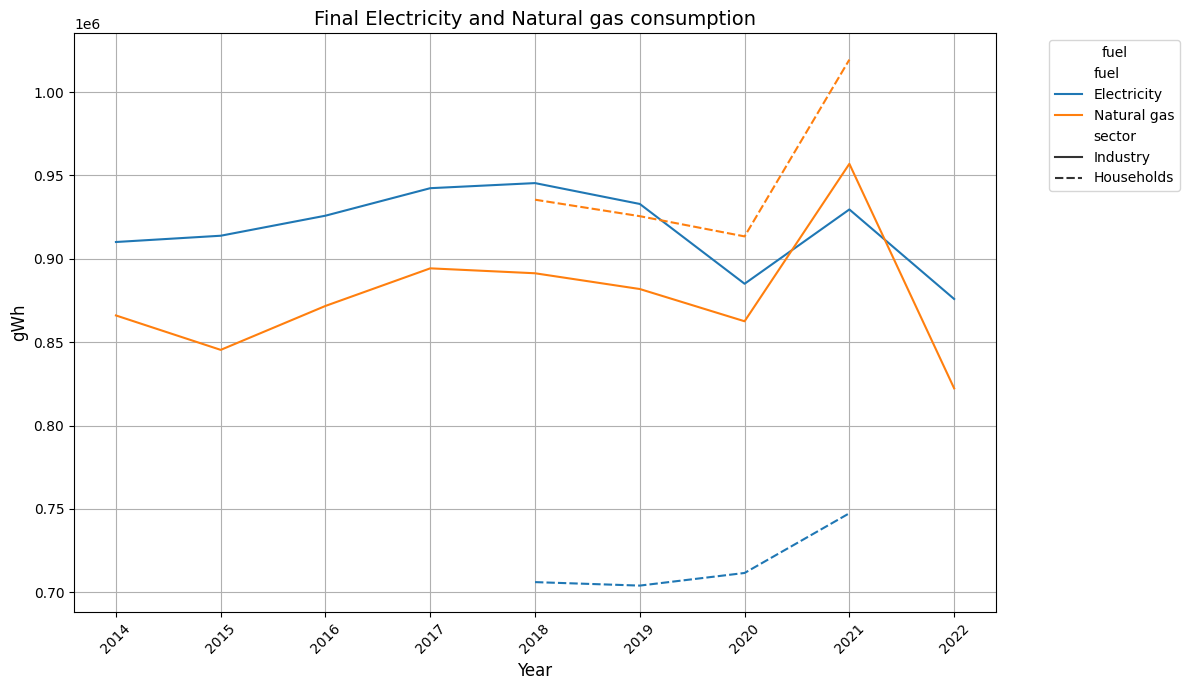

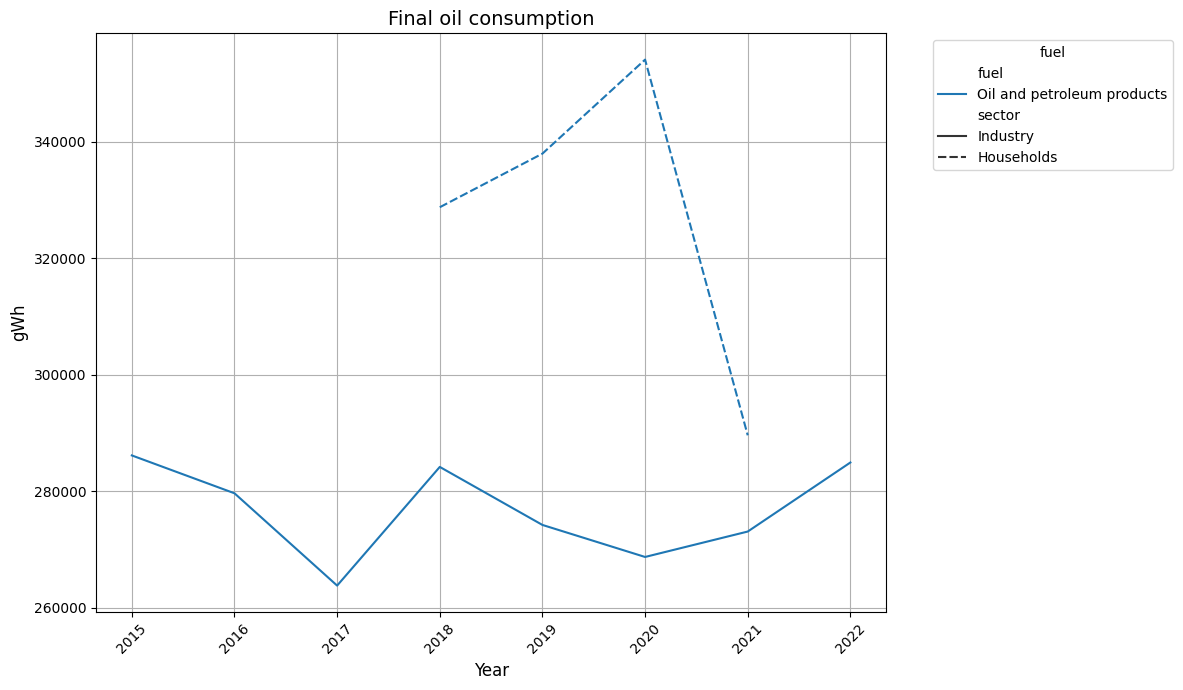

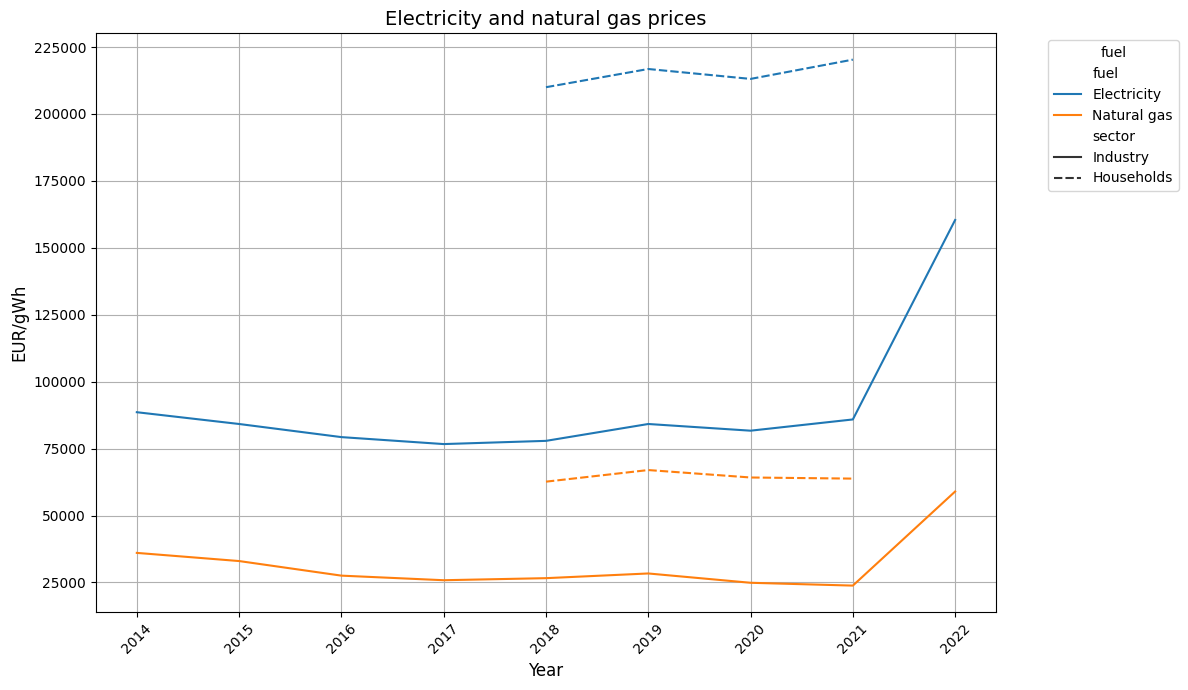

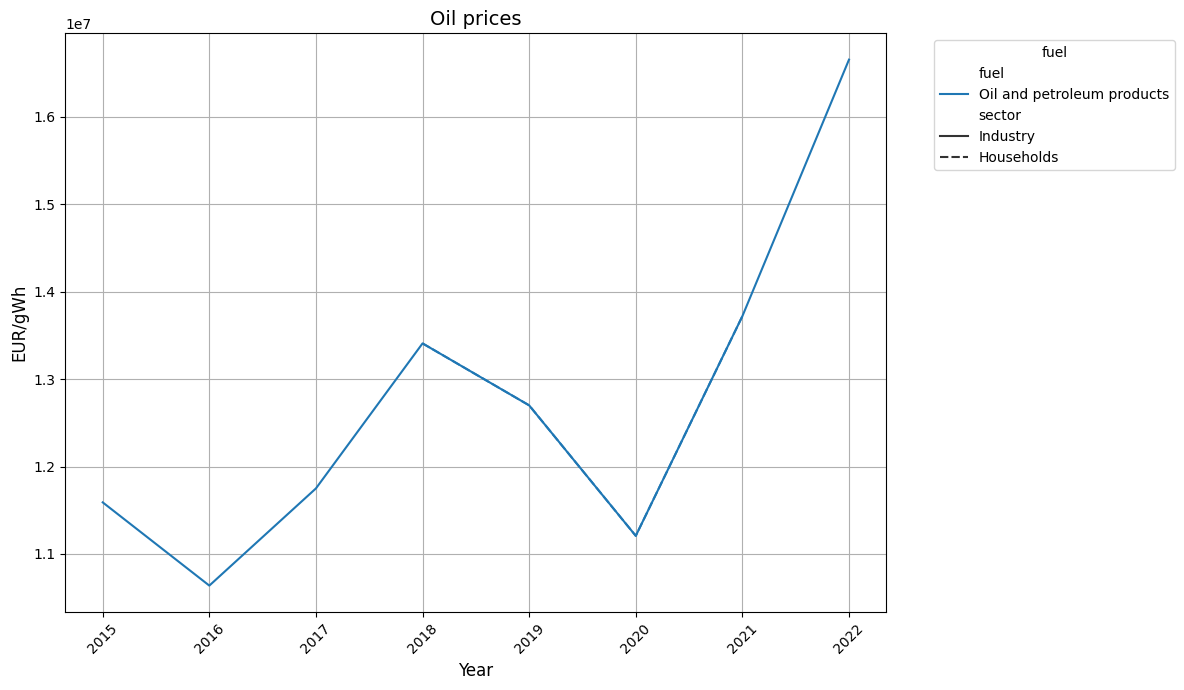

In [109]:
#Plot the consumption data for electricty and natural gas
plot_multi_category(df_q3[df_q3['fuel'] != 'Oil and petroleum products'], 'year', 'gwh', 'fuel', 'sector', 'Final Electricity and Natural gas consumption', 'gWh')

#Plot the consumption data for oil separately due to scaling reasons
plot_multi_category(df_q3[df_q3['fuel'] == 'Oil and petroleum products'], 'year', 'gwh', 'fuel', 'sector', 'Final oil consumption', 'gWh')

#Plot the price data for electricty and natural gas
plot_multi_category(df_q3[df_q3['fuel'] != 'Oil and petroleum products'], 'year', 'price_eur_per_gwh', 'fuel', 'sector', 'Electricity and natural gas prices', 'EUR/gWh')

#Plot the price data for oil separately due to scaling reasons
plot_multi_category(df_q3[df_q3['fuel'] == 'Oil and petroleum products'], 'year', 'price_eur_per_gwh', 'fuel', 'sector', 'Oil prices', 'EUR/gWh')

When analysing the development of fuel prices in the European Union using the two charts shown, it becomes clear that electricity prices are consistently higher than the prices for natural gas. The higher electricity costs can be attributed to the higher production and distribution costs, inefficiencies in generation and the capital-intensive infrastructure. Electricity is also subject to different regulatory frameworks, which could contribute to these higher prices.

From 2021, a significant price increase for all energy sources can be made out, which is likely due to a combination of factors, such as increased demand as the economy recovers from the pandemic, supply chain bottlenecks and geopolitical tensions. This increase is particularly pronounced in the oil sector, where prices rise dramatically from 2021 to 2022. This increase could reflect the specific impact of geopolitical instability on oil supply and the EU's dependence on oil imports.

Furthermore, household prices for both electricity and natural gas are significantly higher than industrial prices. This difference can be accounted to the fact that household tariffs include additional costs for energy distribution and retail, which are disproportionately high for smaller consumption volumes. Households are generally unable to negotiate prices like industry, which can buy energy in large quantities and therefore benefits from more favourable conditions. The rising trend in prices, emphasises the greater financial impact on households compared to industrial consumers.

One thing, that is noticed when looking at the plots and the printed data, is that the x-axis differs between different sectors. This is a side-effect of us wanting to use the same data_frame for all questions in order to not have different subsidies or other side effects, that different data sets might provide, disrupt the cohesiveness of our analysis and hence introduce biases into our results. As prices for all three fuel types types align quite well between different sectors and consumption rates for households are considerably lower than those of the industry sector, we chose to prioritise data quality and not to introduce another set into the analysis in order to remedy the shorter x-axis of household data.


### Correlation: prices and consumption

Next, we will answer the first part of this segment's question: 

*How do fluctuations in electricity, natural gas and oil end-user prices, affect the consumption of these goods (correlation, other influences)?*

In order to do so, we group the prices and consumptions of each fuel type per sector in one graph, plot them and then perform a correlation analysis on them.

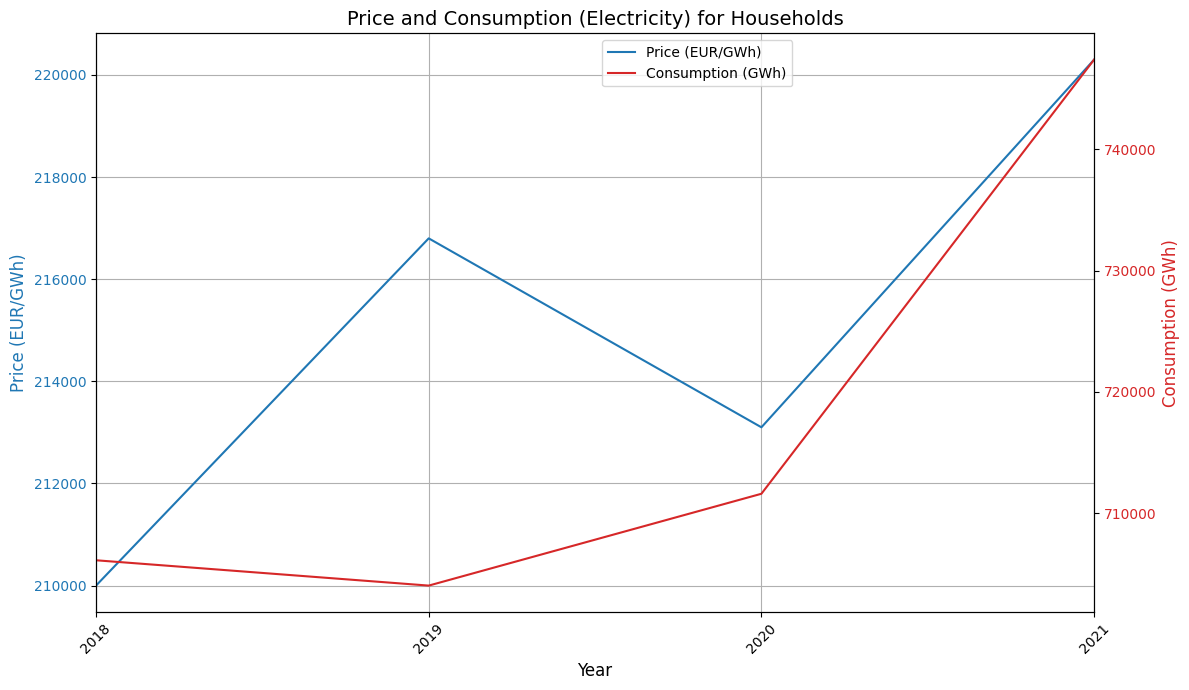

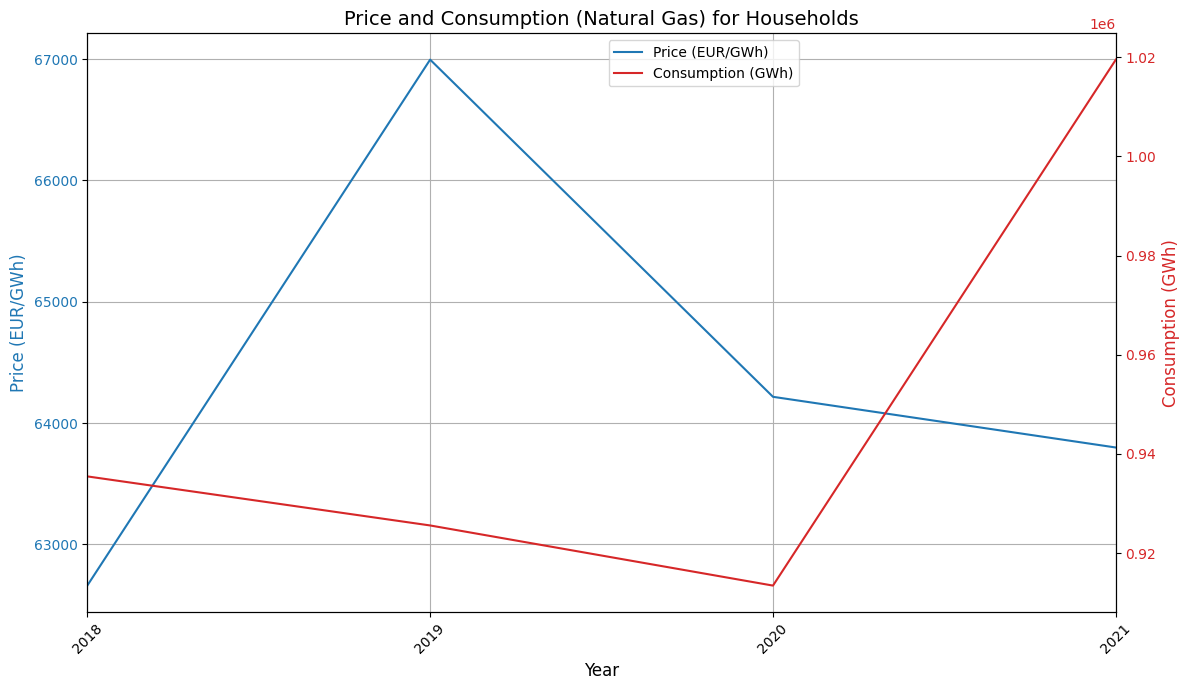

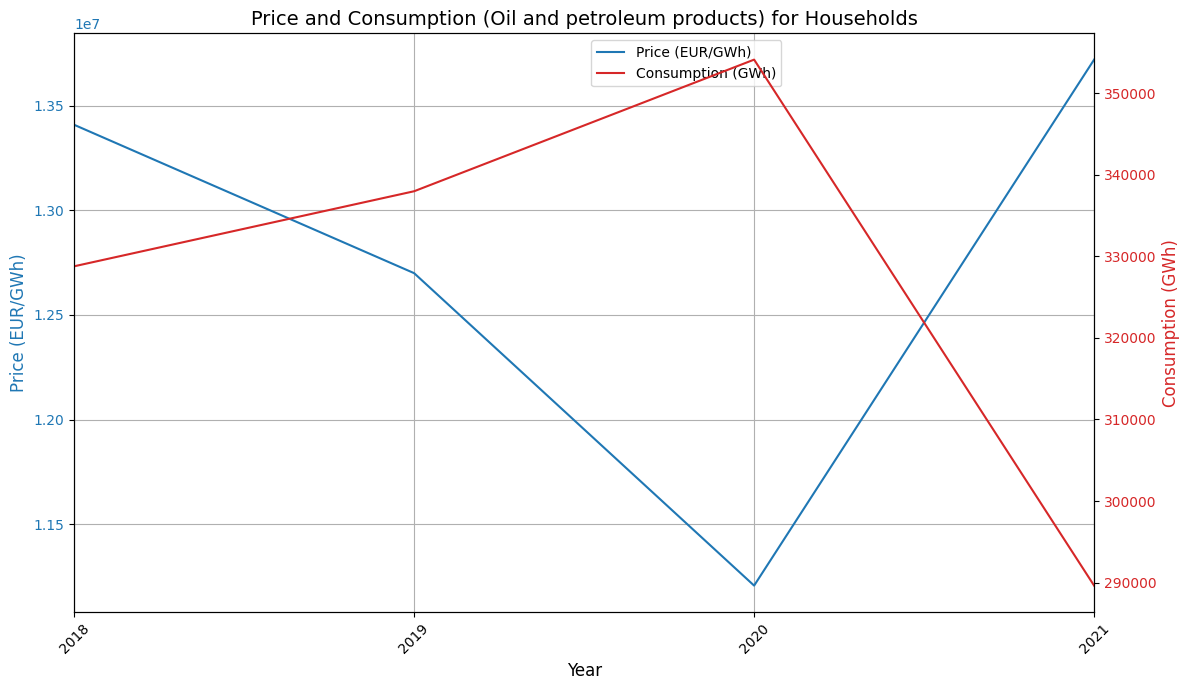

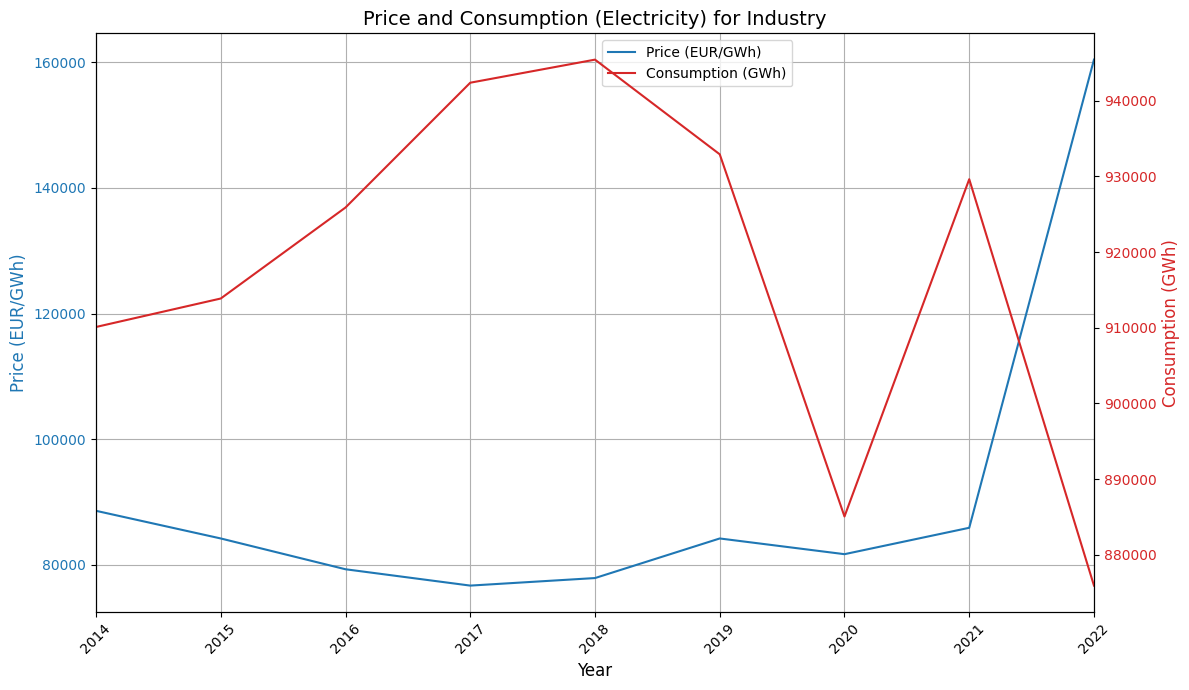

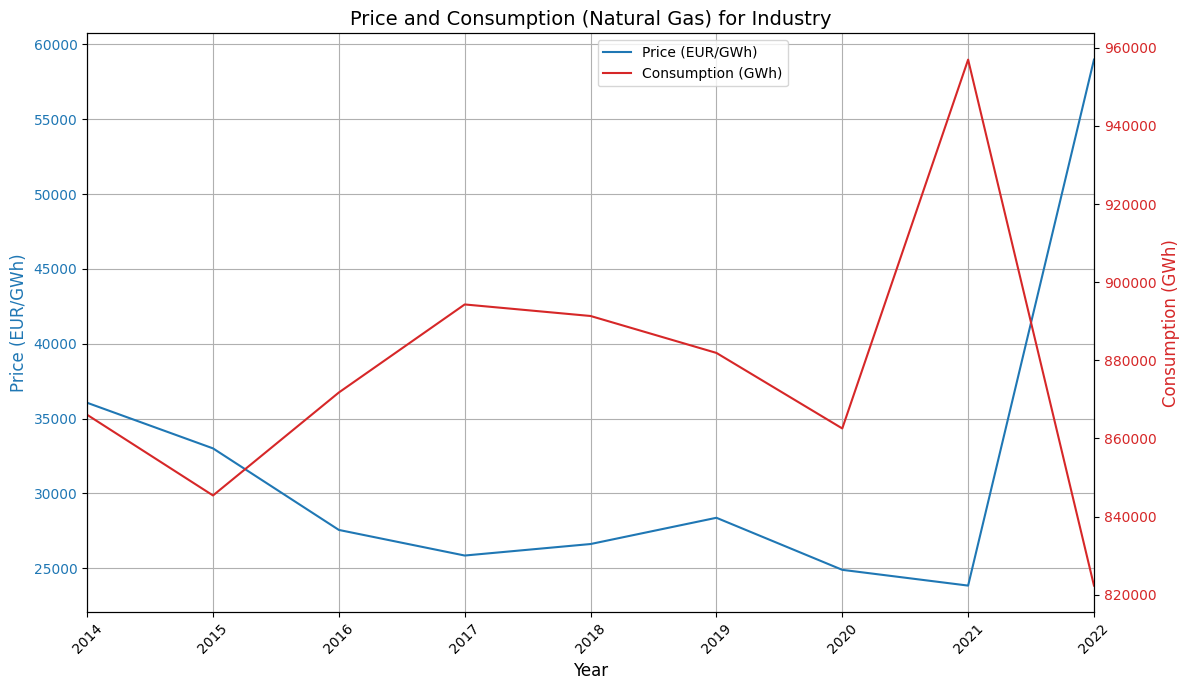

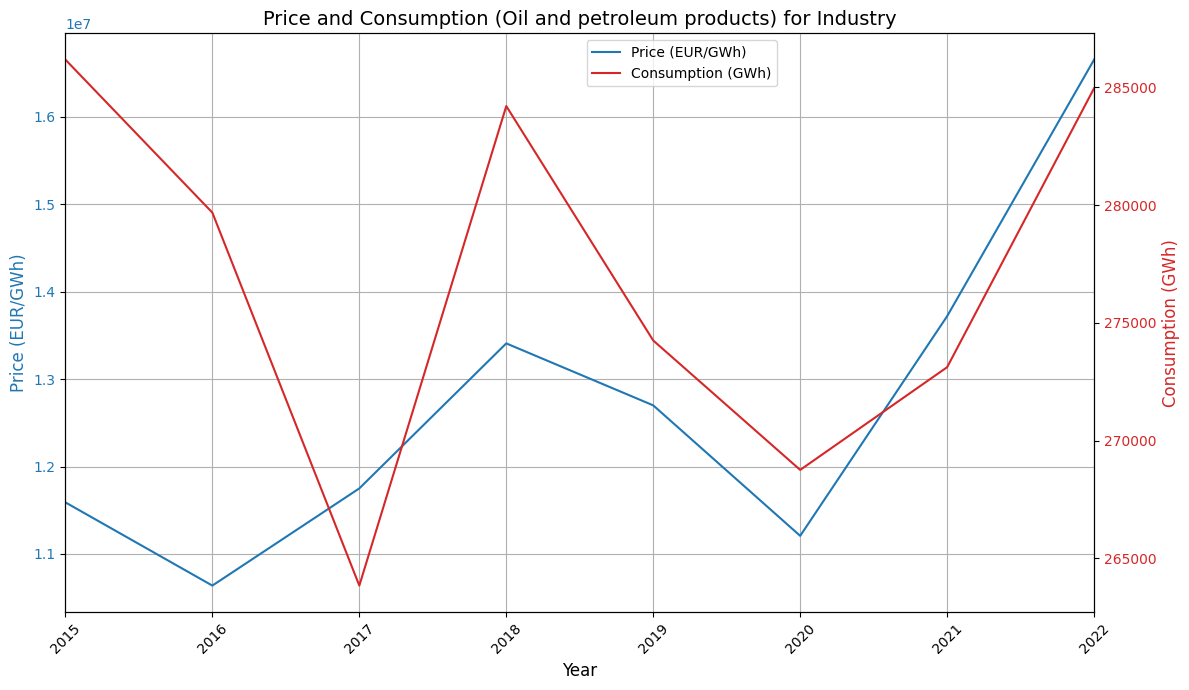

In [110]:
#Plot oil prices for households and industry
df_q3_sectorGrouped = df_q3.groupby(['sector'])
for key, group in df_q3_sectorGrouped:
    plot_dual_axis(group[group['fuel'] == 'Electricity'], 'year', 'price_eur_per_gwh', 'gwh', f'Price and Consumption (Electricity) for {key[0]}', 'Price (EUR/GWh)', 'Consumption (GWh)')
    plot_dual_axis(group[group['fuel'] == 'Natural gas'], 'year', 'price_eur_per_gwh', 'gwh', f'Price and Consumption (Natural Gas) for {key[0]}', 'Price (EUR/GWh)', 'Consumption (GWh)')
    plot_dual_axis(group[group['fuel'] == 'Oil and petroleum products'], 'year', 'price_eur_per_gwh', 'gwh', f'Price and Consumption (Oil and petroleum products) for {key[0]}', 'Price (EUR/GWh)', 'Consumption (GWh)')

In [111]:
# Initialize an empty dictionary to store correlation values
correlation_dict = {'Households': {}, 'Industry': {}}

# Calculate correlation between price and consumption for each fuel type
for key, group in df_q3_sectorGrouped:
    sector = key[0]
    fuel_groups = group.groupby(['fuel'])

    for fuel, fuel_group in fuel_groups:
        price_consumption_correlation = fuel_group['price_eur_per_gwh'].corr(fuel_group['gwh'])
        # Storing the correlation in the dictionary
        correlation_dict[sector][fuel] = price_consumption_correlation

# Convert the dictionary to a DataFrame
correlation_df = pd.DataFrame(correlation_dict)

# Plotting the heatmap for the correlation values
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0)
plt.title('Correlations between Price and Consumption rates by Fuel Type in the European Union', fontsize=10)
plt.ylabel('')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

Based on the plot and the numerical evaluations, we were able to draw the following conclusions:

**Price sensitivity and consumption patterns**: The data shows a different degree of price sensitivity between households and industries. Households react less elastically to price changes, with a negative correlation being most significant for oil consumption (-0.84). This indicates that household consumption falls when oil prices rise, but not as drastically as in the industrial sector. The correlations are lower for electricity and natural gas, which indicates a moderate decline in consumption when prices rise.

In contrast, the industrial sector reacts more elastically, especially for electricity and natural gas, with strong negative correlations (-0.69 and -0.69 respectively). This reflects a greater ability of industrial consumers to reduce energy consumption in response to price increases, likely through efficiency improvements or switching to alternative energy sources.

**Resilience of household consumption**: Household energy consumption patterns tend to be more inelastic as energy use is essential to maintain living standards. The moderately negative correlations suggest that although households are responsive to price changes, their consumption is less flexible due to the necessity of certain energy uses, such as heating, cooking and lighting.

**Industrial adaptability**: The more pronounced negative correlations for industrial electricity and natural gas consumption indicate that this sector is very sensitive to price signals. This can be attributed to the ability of industry to adapt through operational changes, investment in energy efficiency and exploration of alternative energy options to reduce costs.

**Nonlinear dynamics**: The positive correlation for industrial oil consumption (0.38) is intriguing and suggests that as prices increased, so did industrial consumption. This could indicate that certain industrial activities that are dependent on oil could not be easily replaced or reduced, or that economic activity - and thus consumption - increased in times of high oil prices.

**Integrated interpretation**: The correlation coefficients and observed trends indicate that energy consumption is multi-faceted and influenced by economic, technological and behavioural factors. Households tend to adjust their consumption less strongly to price changes, as their energy consumption is essential. In contrast, industry is more flexible and sensitive to price changes, reflecting its focus on cost efficiency and the ability to adapt operations and energy sources.

In summary, while prices are an important determinant of energy consumption, the different correlation values between households and industry underline the complexity of consumption behaviour, which is shaped by a variety of economic conditions, technological advances, regulatory frameworks and inherent differences in energy consumption requirements and flexibility. Therefore, we argue that prices influence demand, as would be expected, but that this relationship is not as obvious as one would expect given the influence of the above factors on consumption rates.

Next, we also want to take into account if the price/consumption relationship has an influence on the percentage of renewable energy sources that are used in the area. Hence we want to answer the question if by raising prices, more renewable sources are used and in this context answer the second part of this segments question:

*How do they affect the share of renewable energy in gross final energy consumption?*

In order to do so, we use the earlier imported data_consumption_renewables data_frame and filter it, once again, for the EU27 entries:

In [112]:
#Filter the data_consumption_renewables data frame for the European Union
eu27_renewables = data_consumption_renewables[data_consumption_renewables['country_code'] == 'EU27_2020']

#Plot the renewable energy consumption in the European Union
plot_multi_category(eu27_renewables, 'year', 'renewable_percentage', 'renewable_energy_share_category', None, 'Renewable energy consumption in the European Union', 'Percentage (%)')

The plot above represents a view of the growth of renewable energy consumption across different sectors in the EU27. It reveals distinct trajectories for the integration of renewables into electricity, heating and cooling, and transport sectors.

**Overall Growth**: The blue line representing the aggregate of renewable energy sources shows a clear upward trend. This indicates a successful expansion of renewable energy within the EU’s energy mix, highlighting progress towards sustainability and energy independence goals. The steady climb reflects ongoing policy support, technologial advancements, and possibly increasing public and corporate commitment to clean energy.

**Electricity Sector**: The organge line, indicating renewables in electricity, shows significant growth. The sector has likely benefited from the rapid scaling of wind and solar power technologies. The relative ease of integrating these technologies into existing grids, along with favorable policies such as feed-in tariffs and renewable purchase obligations, may have contributed to this trend.

**Heating and Cooling**: The slower, yet consistent, rise of the green line suggests a more gradual adoption of renewables in heating and cooling. This could be due to the retrofitting hallenges in existing buildings, the initial costs of installing renewable heating systems, and the slower turnover of heating appliances compared to the more dynamic electricity sector.

**Transport Sector**: The red line, which represents renewables in transport, shows the least growth, with some fluctuations. This sector faces significant challenges due to the entrenched nature of fossil fuel-based infrastructure and vehicles, and the slower development and adoption of renewable alternatives like biofuels, electric, and hydrogen vehicles.

**Intersectoral Comparison**: Comparing the sectors, it's evident that electricity is the front-runner in adopting renewable energy, followed by heating and cooling, with transport lagging behind. These trends could be influenced by varying levels of technological maturity, economic viability, consumer behavior, and policy frameworks in each sector.

In conclusion, the analysis reflects the EU's commitment to increasing the share of renewables, with notable successes and varying rates of progress across sectors. The clear upward trend across all areas suggests a positive trajectory towards renewable energy targets, with the electricity sector leading the charge. However, enhanced efforts appear necessary in the transport sector to accelerate the transition towards sustainable energy consumption.

Next, we want to calculate the correlation between the overall growth of renewable energies and earlier calculated consumption and price rates. 

### Correlation: prices, consumption and  share of renewable energy

Using the data that we presented above, we now want to analyse if a correlation between the price and consumption data and the share of renewable energy can be seen in order to determine if these factors could be used to increase the progress towards a future with only green energy sources.

#### Prepare data

First, we prepare the newly added dataset. Here we only perform some minor ajustments, which are mostly of cosmetic nature, to make the resulting, combined dataframe as easily understandable as possible. 

In [113]:
# Select only the total data
eu27_renewables_total = eu27_renewables[eu27_renewables['renewable_energy_share_category'] == 'Renewable energy sources'].copy()

#drop the renewable_energy_share_category, country_code and country columns
eu27_renewables_total.drop(['renewable_energy_share_category', 'country_code', 'country'], axis=1, inplace=True)

#display the data
display(eu27_renewables_total)

year renewable_percentage
12    2008               12.552
164   2009                13.85
316   2010               14.405
468   2011               14.547
620   2012               16.002
772   2013               16.659
924   2014               17.416
1076  2015                17.82
1228  2016               17.978
1380  2017               18.411
1532  2018               19.096
1684  2019               19.887
1836  2020               22.038
1988  2021               21.926
2140  2022                23.02

Next, we create a dataframe that contains the data of prices and consumption. Here, we first calculate the total consumption in gwh of our different energy types and then calculate the the weighted average price according to their consumption rates. This is necessary, due to the fact, that the renewables dataset only contains the general percentage of renewable energy sources. Next we merge the created set with the eu27_renewables_total that has been created above. By doing so, we derive a set the aligns consumption rates, weighted prices of those consumptions and the share of renewable energy in one comprehensive dataframe.

In [114]:
#create a new dataframe containing the sum of the consumptions of the df_q3 and call that column total_gwh
df_q3_renewables_corr = df_q3.groupby(['year'])['gwh'].sum().reset_index()
df_q3_renewables_corr.rename(columns={'gwh': 'total_gwh'}, inplace=True)

#add the according to the consumption weighted price_eur_per_gwh of each year to the df_q3_sum dataframe and call that column weighted_price_eur_per_gwh
df_q3_renewables_corr['price_eur_per_gwh'] = df_q3.groupby(['year'])['price_eur_per_gwh'].apply(lambda x: np.average(x, weights=df_q3.loc[x.index, 'gwh'])).reset_index()['price_eur_per_gwh']
df_q3_renewables_corr.rename(columns={'price_eur_per_gwh': 'weighted_price_eur_per_gwh'}, inplace=True)

#merge the dataframe with the eu27_renewables_total dataframe and rename the column to total_renewable_percentage
df_q3_renewables_corr = pd.merge(df_q3_renewables_corr, eu27_renewables_total, on='year', how='left')
df_q3_renewables_corr.rename(columns={'renewable_percentage': 'total_renewable_percentage'}, inplace=True)

#make all values in the frame numeric
df_q3_renewables_corr = df_q3_renewables_corr.apply(pd.to_numeric)

#display the dataframe
display(df_q3_renewables_corr)

year     total_gwh  weighted_price_eur_per_gwh  total_renewable_percentage
0  2014  1.776157e+06                6.297805e+04                      17.416
1  2015  2.045451e+06                1.672858e+06                      17.820
2  2016  2.077345e+06                1.479236e+06                      17.978
3  2017  2.100537e+06                1.521277e+06                      18.411
4  2018  4.091354e+06                2.083205e+06                      19.096
5  2019  4.056650e+06                1.995028e+06                      19.887
6  2020  3.995532e+06                1.823226e+06                      22.038
7  2021  4.216271e+06                1.909957e+06                      21.926
8  2022  1.983218e+06                2.488120e+06                      23.020

#### Correlation analysis

Next, we plot the prices and the consumption rates against the percentage of renewable energy sources and calculate the correlations.

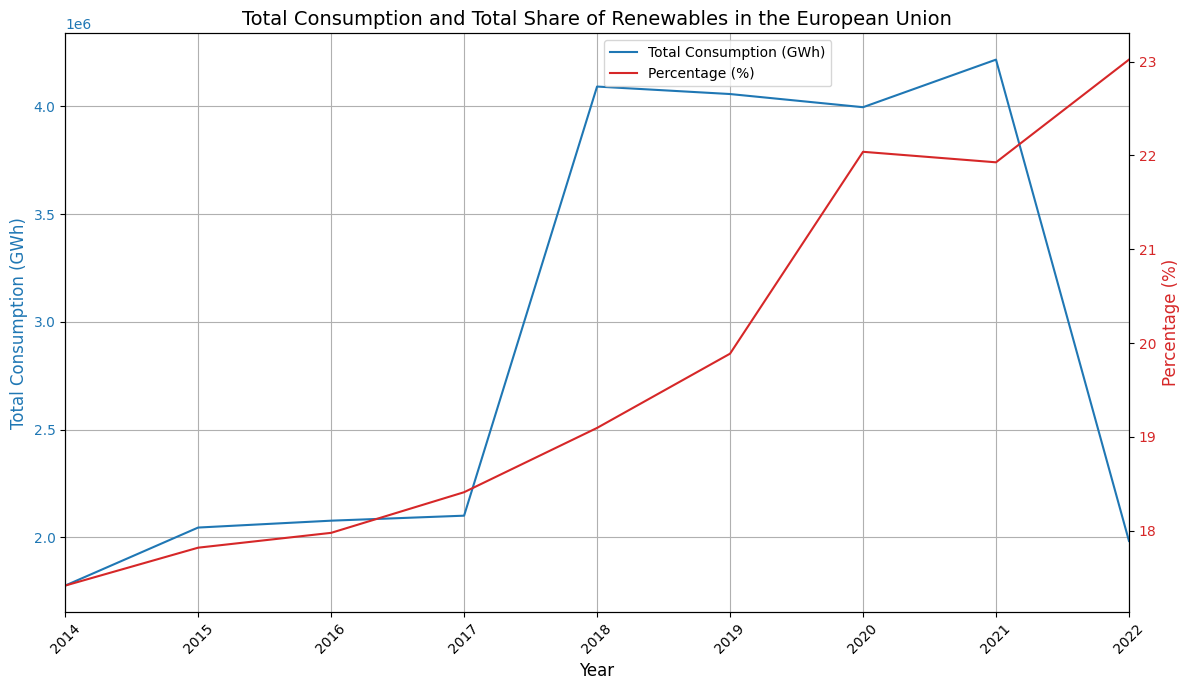

In [115]:
# Plot the data between price and renewables and consumption and renewables
plot_dual_axis(df_q3_renewables_corr, 'year', 'weighted_price_eur_per_gwh', 'total_renewable_percentage', 'Weighted average Price and Total Share of Renewables in the European Union', 'Weighted average Price (EUR/GWh)', 'Percentage (%)')
plot_dual_axis(df_q3_renewables_corr, 'year', 'total_gwh', 'total_renewable_percentage', 'Total Consumption and Total Share of Renewables in the European Union', 'Total Consumption (GWh)', 'Percentage (%)')

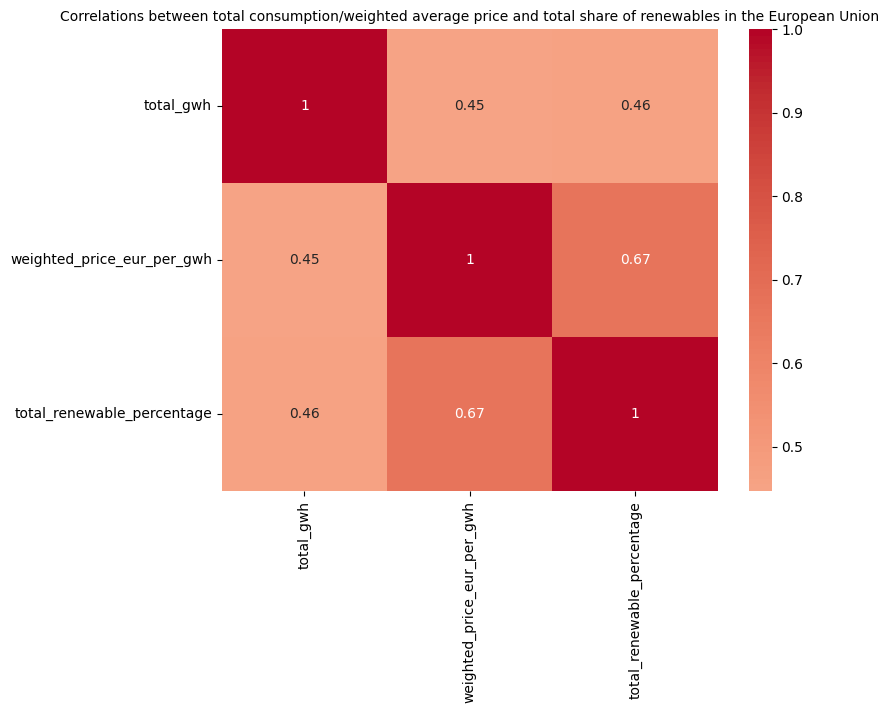

In [116]:
# Now let's calculate the correlation matrix for the DataFrame
correlation_matrix = df_q3_renewables_corr.drop('year', axis=1).corr()

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, center=0, cmap='coolwarm')
plt.title('Correlations between total consumption/weighted average price and total share of renewables in the European Union', fontsize=10)
plt.show()

Based on the plots and the calculation results we can draw the following insights:

**Price versus Renewable Energy Share**: The positive correlation (0.67) implies that as the average price of energy in the EU rises, the share of renewable energy in the mix also increases. This trend may reflect a growing integration of renewable energy due to higher costs of conventional energy sources, as well as proactive measures to enhance energy sustainability through increased renewable energy production and usage.

**Consumption versus Renewable Energy Share**: The positive correlation (0.46) suggests that as the share of renewable energy in the energy mix increases, the total energy consumption also increases. This could reflect the expanding energy needs of the EU being increasingly met by renewable sources.

**Trends and Policy Implications**: The increase in the share of renewables is consistent with policy objectives and investments aimed at reducing dependence on fossil fuels and combating climate change. The European Union's policies to incentivize renewable energy seem to be reflecting positively on the growing share within the energy mix.

**Economic and Ecological Impact**: The positive correlation between the renewable share and energy prices suggests that renewable energy sources are increasingly competitive and less influenced by traditional energy market fluctuations. This can contribute to economic stability by mitigating the impacts of fossil fuel price volatility and advancing ecological benefits through reduced carbon emissions.

In summary, the transition to renewable energy in the EU is evident and appears to be partly influenced by energy pricing dynamics. While the consumption of energy does not show a strong inverse relationship with the share of renewables, the positive trend in renewable energy adoption is clear, signifying a policy-driven shift toward a more sustainable energy system. The data points towards a deliberate move to enhance the role of renewables in the EU's energy portfolio, which may continue to evolve with advancements in technology and further policy support.

### Conclusion

Based on the insights, that we were able to gain above, we can draw the following conclusions in answering this sections guiding question:

*How do fluctuations in electricity and natural gas end-user prices, affect the consumption of these goods (correlation, other influences)? How do they affect the share of renewable energy in gross final energy consumption?*

Our analysis indicates that non-households are, as expected, more responsive to changes in energy prices compared to households. We accredit this, as also commonly done in macroeconomics, to a greater flexibility in managing energy consumption. Rising energy prices also correlate with an increased share of renewable energy, suggesting a strategic pivot towards more sustainable energy sources, bolstered by policy measures and technological advancements. This shift reflects the EU's broader commitment to sustainability and energy diversification.

## Question 4 (Marko Gugleta)

Identify the main external and internal sources of fossil fuels for European Union. How has the reliance on these sources shifted over time?

### Describing the data
Before visualisations and coming to any conclusions, it is very important to understand what the data is all about and what it contains. The columns represent the following:
 - freq: Time frequency. In this dataset all of the frequencies are annual (A).
 - siec: Standard international energy product classification. In this dataset all of the values are O4000XBIO, which references oil and petroleum products.
 - partner: geopolitical entity (partner).
 - unit: Unit of measure, in this dataset Percentage (PC).
 - geo: geopolitical entity (reporting).
 - 2015-2020: data over time.


### Identifying the main external an internal sources of Fossil Fuels for Europe.

This part of the question should be quite direct since we have that information readily available in the dataset. All of the sources should be listed in the *partner* column. We see that the sources are:

In [117]:
nrg_ind_idooil['partner'].unique()

array(['Azerbaijan', 'Algeria', 'Iraq', 'Kazakhstan', 'Libya', 'Nigeria',
       'Norway', 'Russia', 'Saudi Arabia', 'United Kingdom',
       'United States'], dtype=object)

The output shows that the internal sources are:
 - United Kingdom
 - Norway and
 - Russia.

And the external sources are:
 - Azerbaijan
 - Algeria
 - Iraq
 - Kazakhstan
 - Libya
 - Nigeria
 - Saudi Arabia and
 - United States
  
Next step in answering the question would be to see how reliance on these sources has shifter overtime. The best way to do this would be to do it though visualisation of the data.

### Visualize data
As in to get a feel of the data, we can first plot an example for one country, and after we can shift the focus to the more general overview. Let's use Austria as an example.

In [118]:
country = "Austria"
plot_imports_all(nrg_ind_idooil, country)

/var/folders/9b/ztby2vp10jxgc26kbjm6slr80000gn/T/ipykernel_73540/784888155.py:159: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[c, r].set_xticklabels(dataset['partner'].unique())


This plot shows how for every year the distribution of imported oil from each country looks like. Here it can be seen how much Austria depends on imports based on the country.

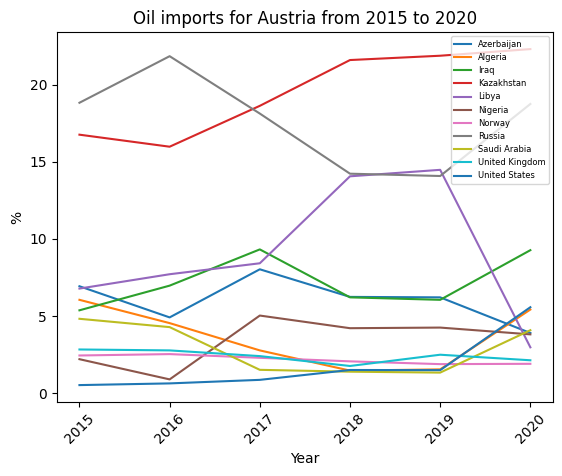

In [119]:
plot_changes(nrg_ind_idooil, country)

This next plot basically shows an overview on the plots above which helps us showcase the change overtime.

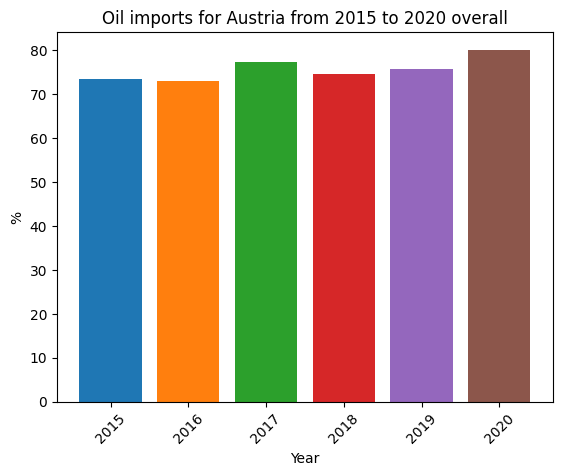

In [120]:
plot_overall(nrg_ind_idooil, country)

This plot shows the overall percentage of oil that was imported in Austria, spanned in the given time interval. This is a very important plot, since it shows how much a country depends on import in order to satisfy their oil needs.

Now lets take a look at how much every country in Europe imports fuel. We can do that by taking the mean for each year and plotting it in the same manner as the last plot.

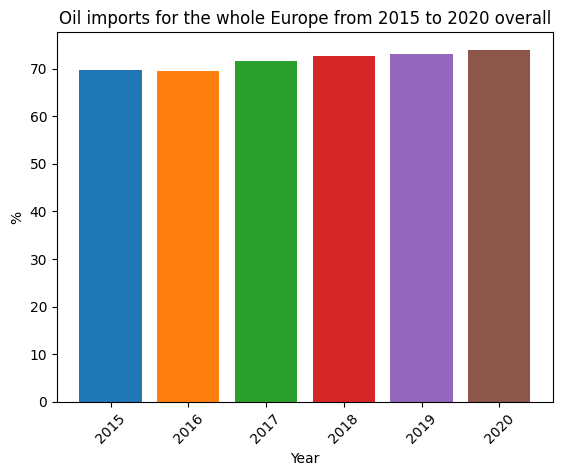

In [121]:
plot_overall_all(nrg_ind_idooil)

Here we can conclude that Europe's need for imported oil is increasing overtime, probably due to multiple reasons like increased consumption and less internal production. We can take a look at the cost of oil and petroleum products onece again and maybe try to find some correlation between importing and rising of prices, since usually what happens if more stuff is imported, the prices rise due to customs taxes.

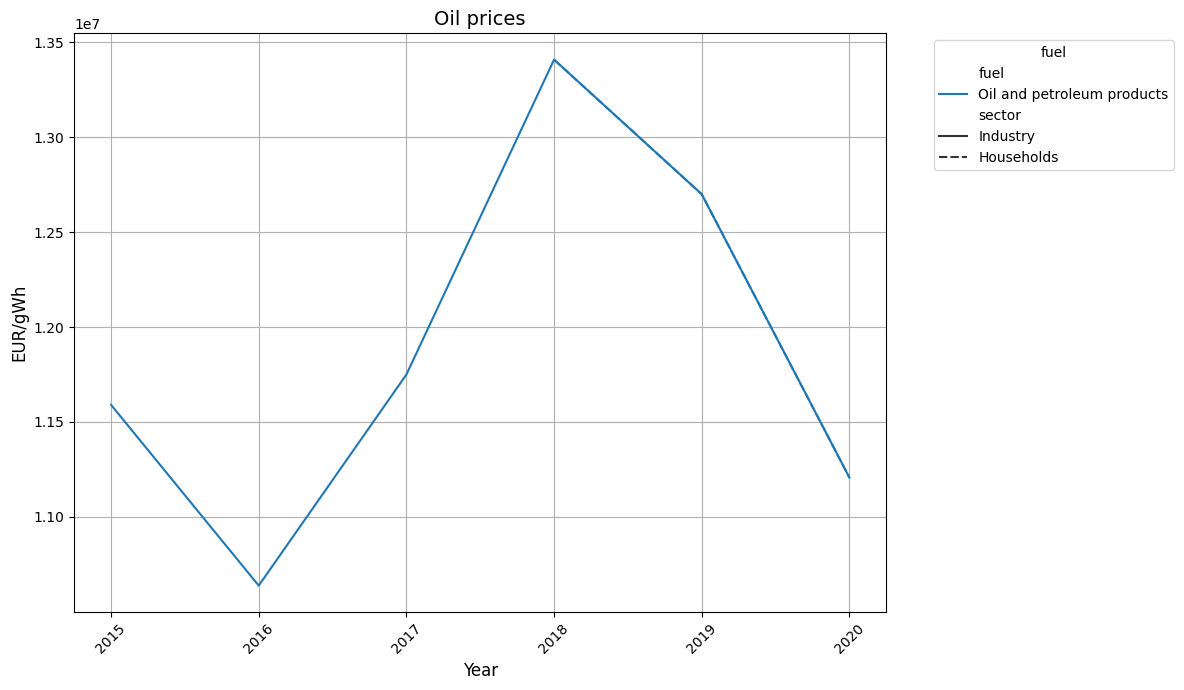

In [122]:
plot_multi_category(df_q3[(df_q3['fuel'] == 'Oil and petroleum products') & (df_q3['year'] <= 2020)], 'year', 'price_eur_per_gwh', 'fuel', 'sector', 'Oil prices', 'EUR/gWh')

Interestingly enough, we see that in 2016, when the price plummets, the import precentage decreases as well. But, in the next 2 years when the prices increase drastically, the import precentage increases as well. For now the correlation is visible, but in the next two years, when the price stats to decrease, the import precentage says on the rising path. This is interesting to see and hard to interpret, since there are a lot of factors that could influence this. Lets take a look at the overall imports from independent countries since there might be some insight there.

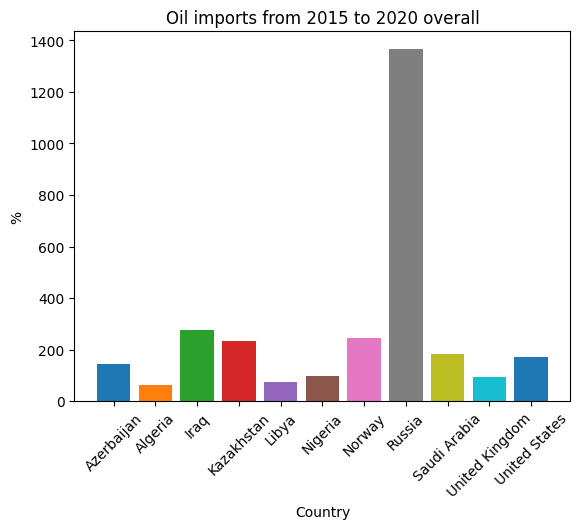

In [123]:
plot_overall_partner(nrg_ind_idooil)

This last plot shows how much actually the countries in this period depended on which importer, which clearly highlights that Russia was the most important trading partner. Additionally, to see these changes overtime, we can separate them in one plot per year.

/var/folders/9b/ztby2vp10jxgc26kbjm6slr80000gn/T/ipykernel_73540/784888155.py:231: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[c, r].set_xticklabels(dataset['partner'].unique())
/var/folders/9b/ztby2vp10jxgc26kbjm6slr80000gn/T/ipykernel_73540/784888155.py:231: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[c, r].set_xticklabels(dataset['partner'].unique())
/var/folders/9b/ztby2vp10jxgc26kbjm6slr80000gn/T/ipykernel_73540/784888155.py:231: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[c, r].set_xticklabels(dataset['partner'].unique())
/var/folders/9b/ztby2vp10jxgc26kbjm6slr80000gn/T/ipykernel_73540/784888155.py:231: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[c, r].set_xticklabels(dataset['partner'].unique())
/var/folders/9b/ztby2vp10jxgc26kbjm6slr80000gn/T/ipykernel_73540/784888155.py:231: UserWarning: FixedFormatter should only be used together with

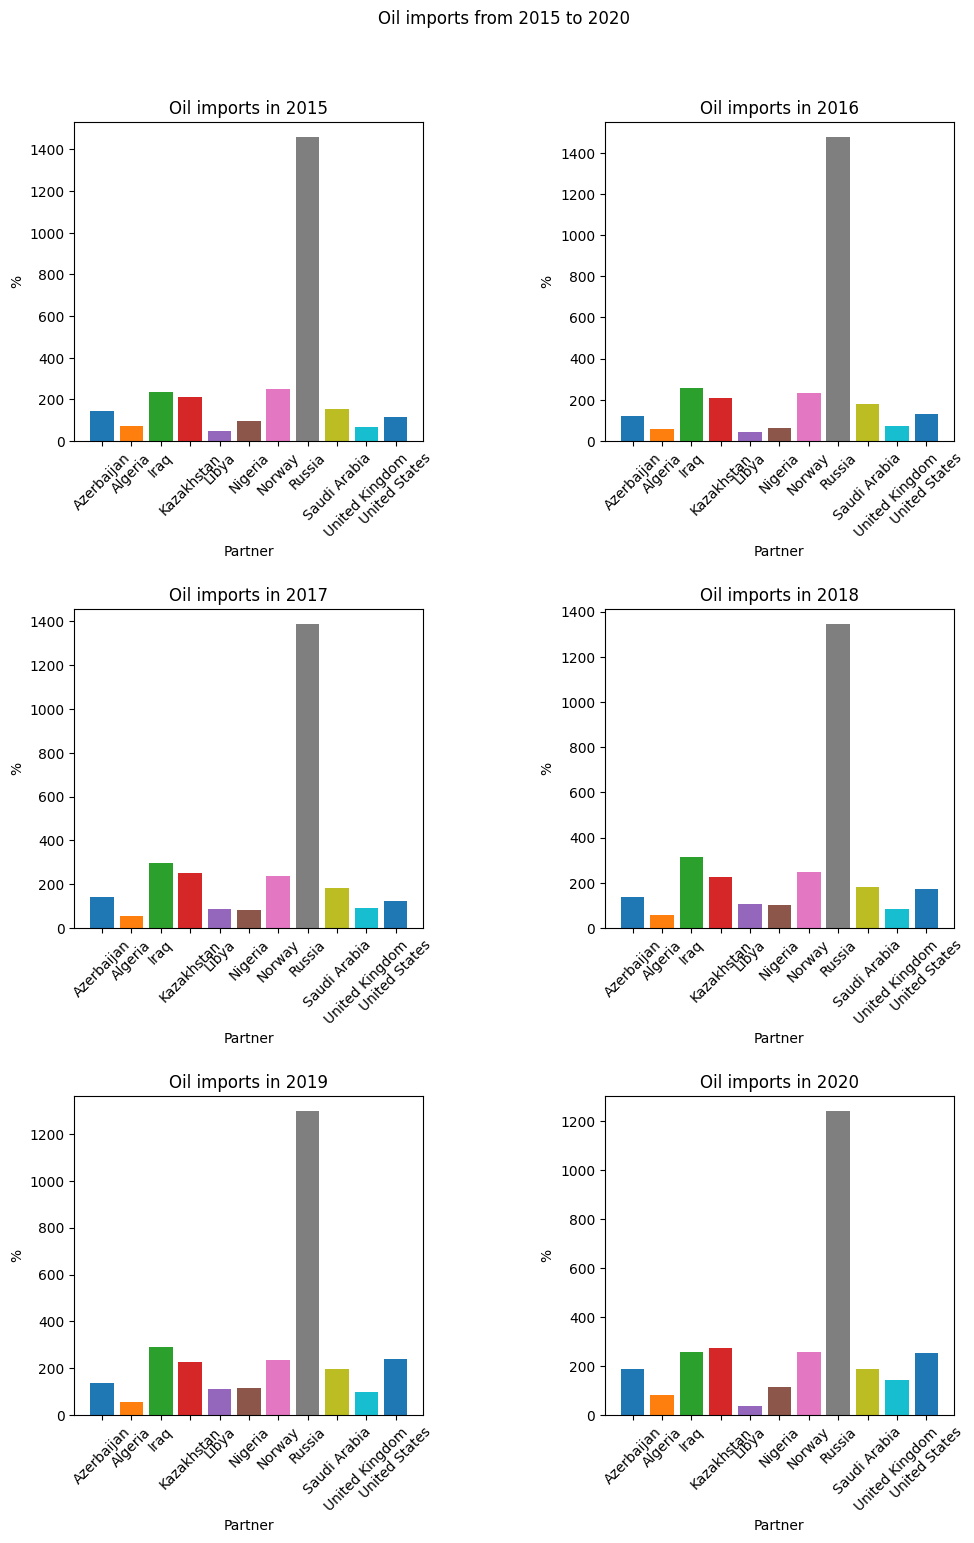

In [124]:
plot_yearly_partner(nrg_ind_idooil)

We can see that in the last two years that are plotted, the values for Russia, which is the most significant importer, decreases, while the imports from some other countries increase. This could be one of the reasons why the inverse correlation happens in the last two years shown.

### Conclusion

In this section we answered the question about who the main sources of fossil fuels for Europe are, and have shown visually how the relicance on the souces changes overtime. Overall, a lot of countries in Europe depend highly on the imported fuel, most of it coming from Russia. Other countries provide approximately the same amount, except Algeria, Libya and Nigeria which export the least between the others. 

Looking at the reliance overtime, we don't see any significant significant change that would indicate something major has influenced the trade between the importers and Europe. Unfortunately, this is a pretty short time period to show any significant change. For example, looking at the data later on (2022, 2023) where there were changes in the means of world events, the change would probably be more significant. Sadly, there was no data available for the further time period but it would be interesting to see how the relationship between Europe and Russia changed after the sanctions that were imposed back in 2021.

## Final Conclusion

### Final overview of the results
This analysis has looked in depth at the European Union's energy landscape, focussing on the region's transition from fossil fuels to renewable energy sources. Our research answered key questions about the EU's dependence on different types of fossil fuels, the primary use of these fuels in industry and households, and the impact of fluctuating end-user prices on consumption patterns and renewable energy deployment. An important aspect of our analysis was to identify the main external and internal sources of fossil fuels in the EU and to analyse how dependence on these sources has evolved over time. The insights gained from this study provide a comprehnsive overview of energy dynamics in the EU, highlighting both the progress made in integrating renewable energy and the ongoing challenges in reducing fossil fuel dependence.

### Potential biases in data and analysis
While our analysis provides valuable insights, it is important to recognise potential biases. Firstly, the data are primarily recorded transactions and reported figures, which may not capture unreported or informal energy use. Secondly, the analysis is limited by the temporal scope of the available data, which mainly covers the period up to 2020. This limitation means that recent developments, especially those after 2021, are not included in our results. In addition, our interpretations and methods of analysis may inherently be subject to biases that are influenced by our perspective and the assumptions underlying our statistical models. Recognising these biases is critical to a balanced understanding of the analysis.

### Data science tools and techniques learnt
Over the course of this exercise, we refined various data science tools and techniques. Most notably, these included data preprocessing and cleaning, which are essential for ensuring the quality and reliability of our datasets. We made extensive use of Python libraries such as Pandas for data manipulation and Matplotlib and Seaborn for data visualisation, which improved our ability to interpret complex datasets and draw meaningful conclusions. We also applied statistical analysis methods to identify trends and correlations within the data. We also learnt how to critically evaluate and interpret our results, taking into account possible biases and limitations in our analysis. This project was not only about analysing data, but also about developing comprehensive data science skills.